# Cryptocurrency Analysis: Latent Space Dependence
### Ali Habibnia and Matt Harrington

---

**Goals**:
1. Grab all relevant coins (defined by subsets in `subsets.py`, default = `top_50`)
1. Fit benchmark latent variable models 
    1. AR(1)
    2. SARIMA
1. Grenerate Latent Features with Encoding Methods
    1. Vanilla AE
    2. Variational AE
    3. Transformer (?)
1. Pass latent features to predictive models
    1. OLS
    2. RNN
    3. LSTM
    4. Forecasting Transformer
---


## Plumbing

In [1]:
import sys
import os

import importlib
is_colab = importlib.util.find_spec("google")
found = is_colab is not None

import_path = ''
if found:
    from google.colab import drive
    drive.mount('/content/gdrive/', force_remount=True)
    import_path += '/content/gdrive/My Drive/Thesis/pairs/'

else:
    import_path += 'pairs/'

print(import_path)

pairs/


In [2]:
from subsets import *
from coin_helpers import load_coins, simplify
coins, returns = load_coins(import_path, top_50)

Log-Returns Head:                           BTC       ETH  BCH  BNB  LINK  DOT  ADA  LTC  EOS  \
open_time                                                                     
2017-08-17 04:01:00  0.000000  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:02:00  0.004467 -0.003759  NaN  NaN   NaN  NaN  NaN  NaN  NaN   
2017-08-17 04:03:00 -0.004467  0.000000  NaN  NaN   NaN  NaN  NaN  NaN  NaN   

                     XMR  ...  UMA  ONT  YFI  SNX  FTT  BTT  ALGO  DGB  DOGE  \
open_time                 ...                                                  
2017-08-17 04:01:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:02:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   
2017-08-17 04:03:00  NaN  ...  NaN  NaN  NaN  NaN  NaN  NaN   NaN  NaN   NaN   

                     REN  
open_time                 
2017-08-17 04:01:00  NaN  
2017-08-17 04:02:00  NaN  
2017-08-17 04:03:00  NaN  

[3 rows x 36 columns]


### Helper functions

In [3]:
# N = number of return periods
def annualised_sharpe(returns, N=252):
    return np.sqrt(N) * (returns.mean() / returns.std())

def multi_get_rolling_samples(ts, lag = 12):
    samples = []
    fifth = round(len(ts.index) / 5)
    for i in range(len(ts.index)):
        if i >= lag:
            if i % fifth == 0:
                print("{} periods done".format(i))
            s = ts.iloc[i-lag: i]
            samples.append(s)

## Setting up import dictionary "coins", returns, and subsets

#### Subsetting

In [123]:
hour_ret = simplify(returns, '1h')
day_ret = simplify(returns, '1D')
print(hour_ret.shape)
print(day_ret.shape)

(30596, 36)
(1275, 36)


In [5]:
n = 365
twoyr, oneyr = [], []
for c in day_ret.columns:
    nulls = day_ret[c].isnull().sum()
    lengs = day_ret[c].shape[0]
    if lengs - nulls > n:
        oneyr.append(c)
        if lengs - nulls > 2*n:
            twoyr.append(c)

n1, n2 = len(oneyr), len(twoyr)
nall = len(returns.columns)
p1 = round(100 * n1 / nall, 2)
p2 = round(100 * n2 / nall, 2)
print("{0} of {1} ({2}%) have more than {3} days of data".format(n1, nall, p1, n))
print("{0} of {1} ({2}%) have more than {3} days of data".format(n2, nall, p2, 2 * n))

26 of 36 (72.22%) have more than 365 days of data
14 of 36 (38.89%) have more than 730 days of data


---
## GLOBAL PARAMETERS
---

In [75]:
# COIN_SUBSET = twoyr
COIN_SUBSET = oneyr
LATENT_DIM = 10
AR_LAGS = 5

---
## Baseline Predictive Models

In [76]:
# Standard imports
import warnings
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
plt.style.use('ggplot')

# For baseline models
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

In [98]:
ts_data = hour_ret[COIN_SUBSET].dropna(how='any')
n, c = ts_data.shape
subplot_rows = (c // 5) + 1
print("{} Samples, {} coins".format(n, c))
print('Thereby, {} (P)ACF subplot rows'.format(subplot_rows))

10053 Samples, 26 coins
Thereby, 6 (P)ACF subplot rows


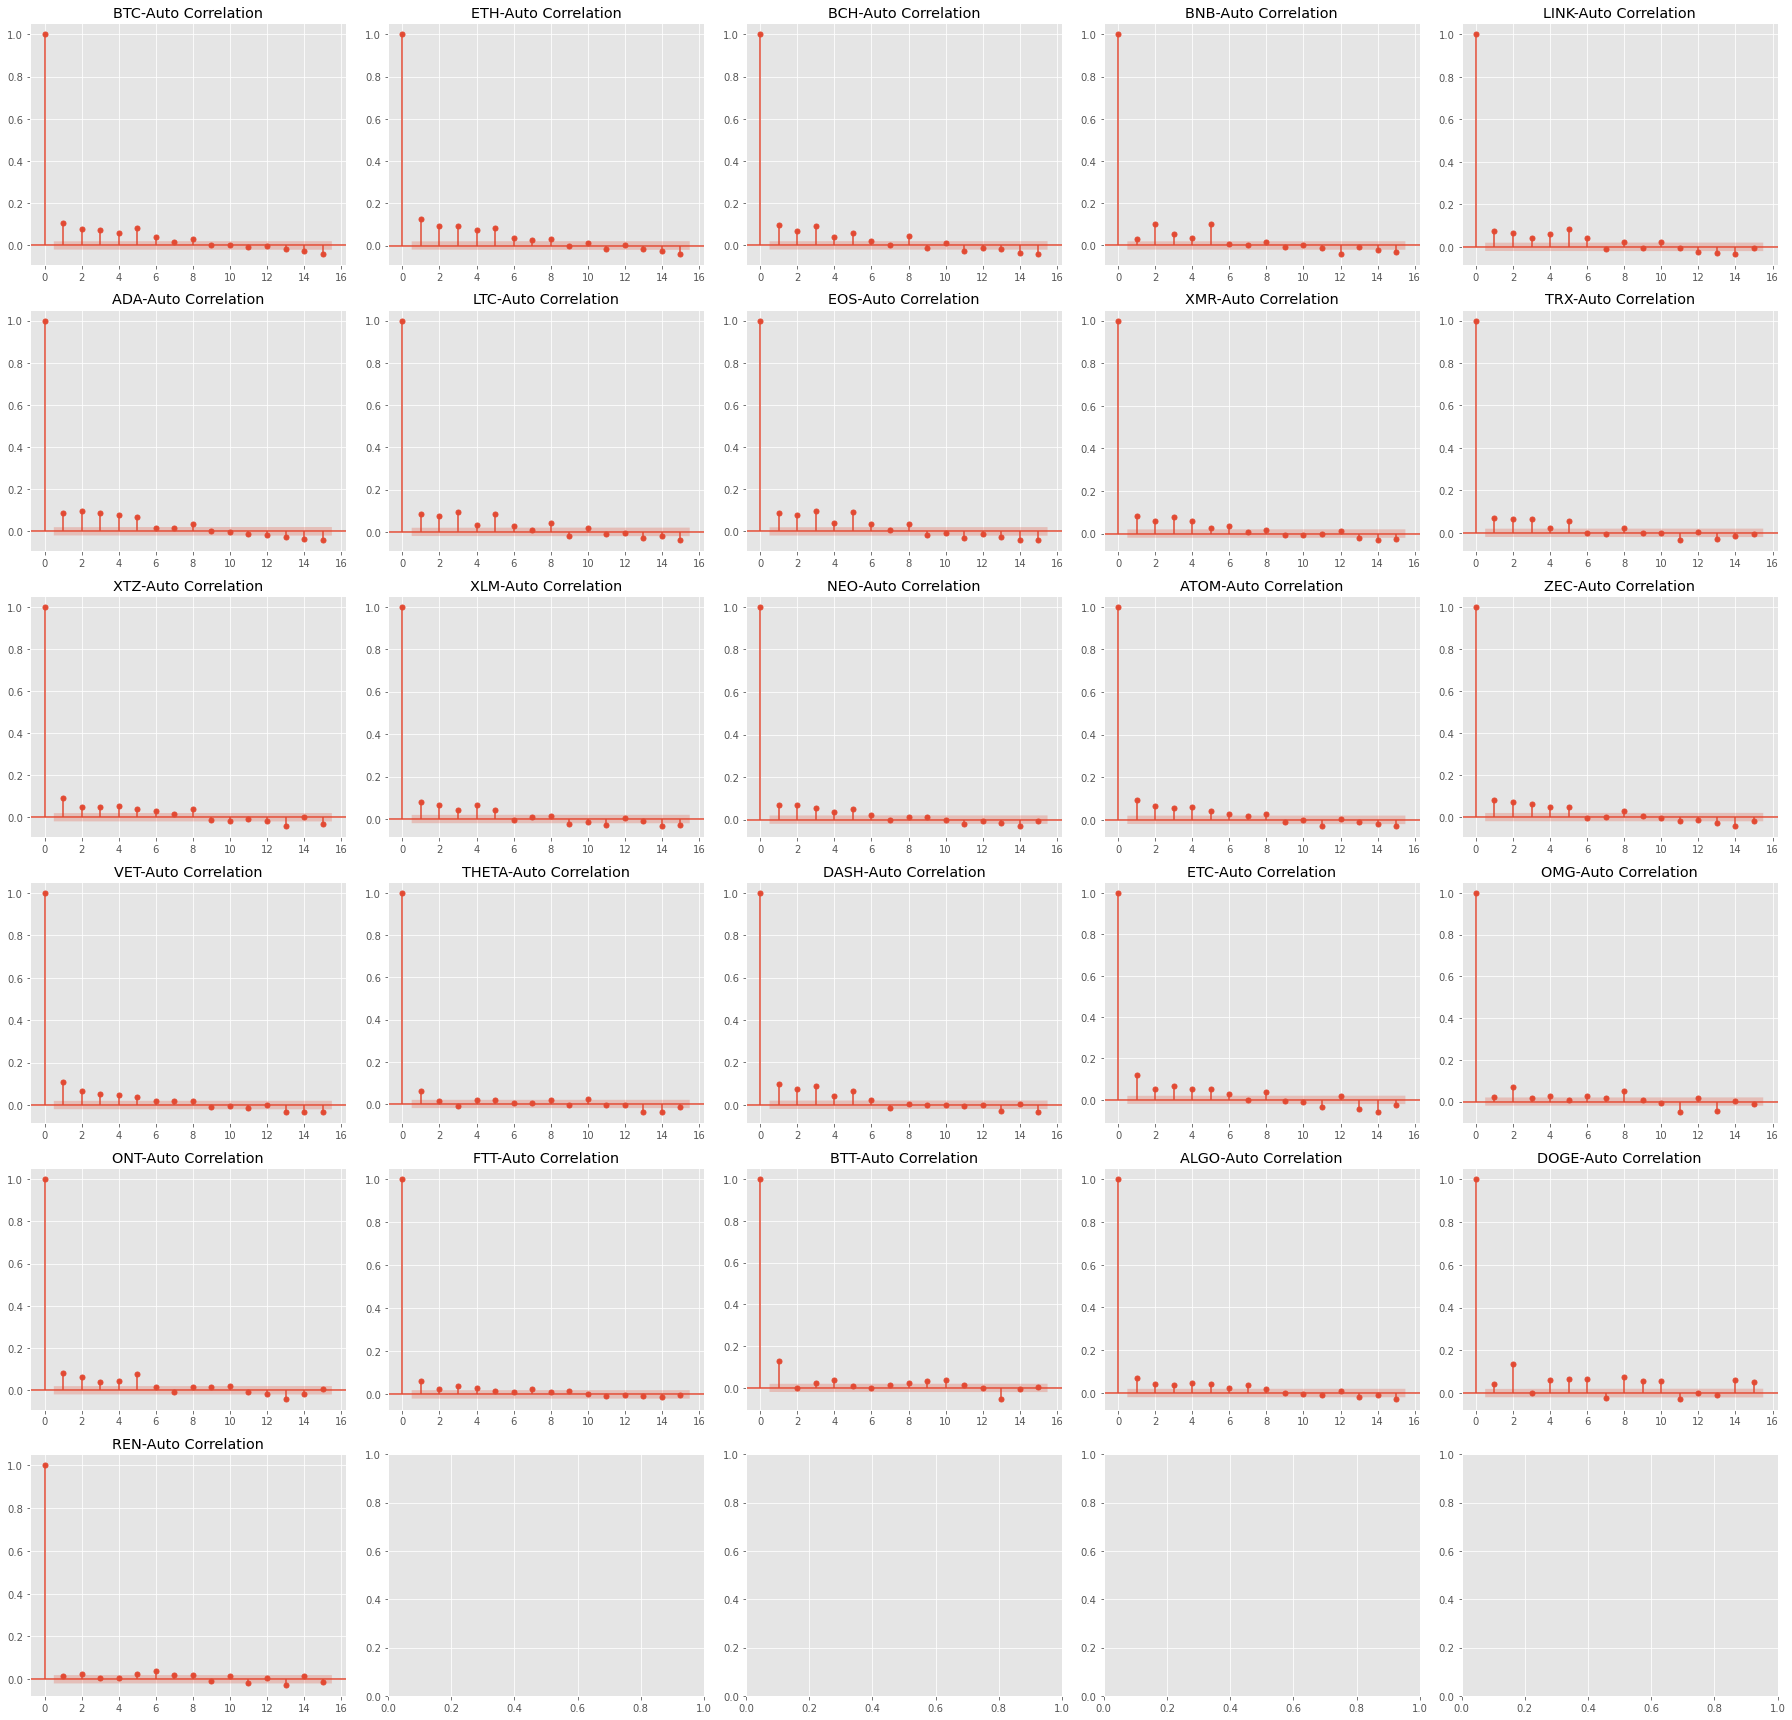

In [99]:
# Graph univariate Autocorrelation Functions
fig, axs = plt.subplots(subplot_rows, 5, figsize=(25,subplot_rows * 4))
i, tscols = 0, ts_data.columns
for row in axs:
    for entry in row:
        if i >= len(tscols):
            break
        coin = tscols[i]
        plot_acf(ts_data[coin], ax=entry, lags=15)
        entry.set_title("{}-Auto Correlation".format(coin))
        i += 1
plt.tight_layout()
plt.show()

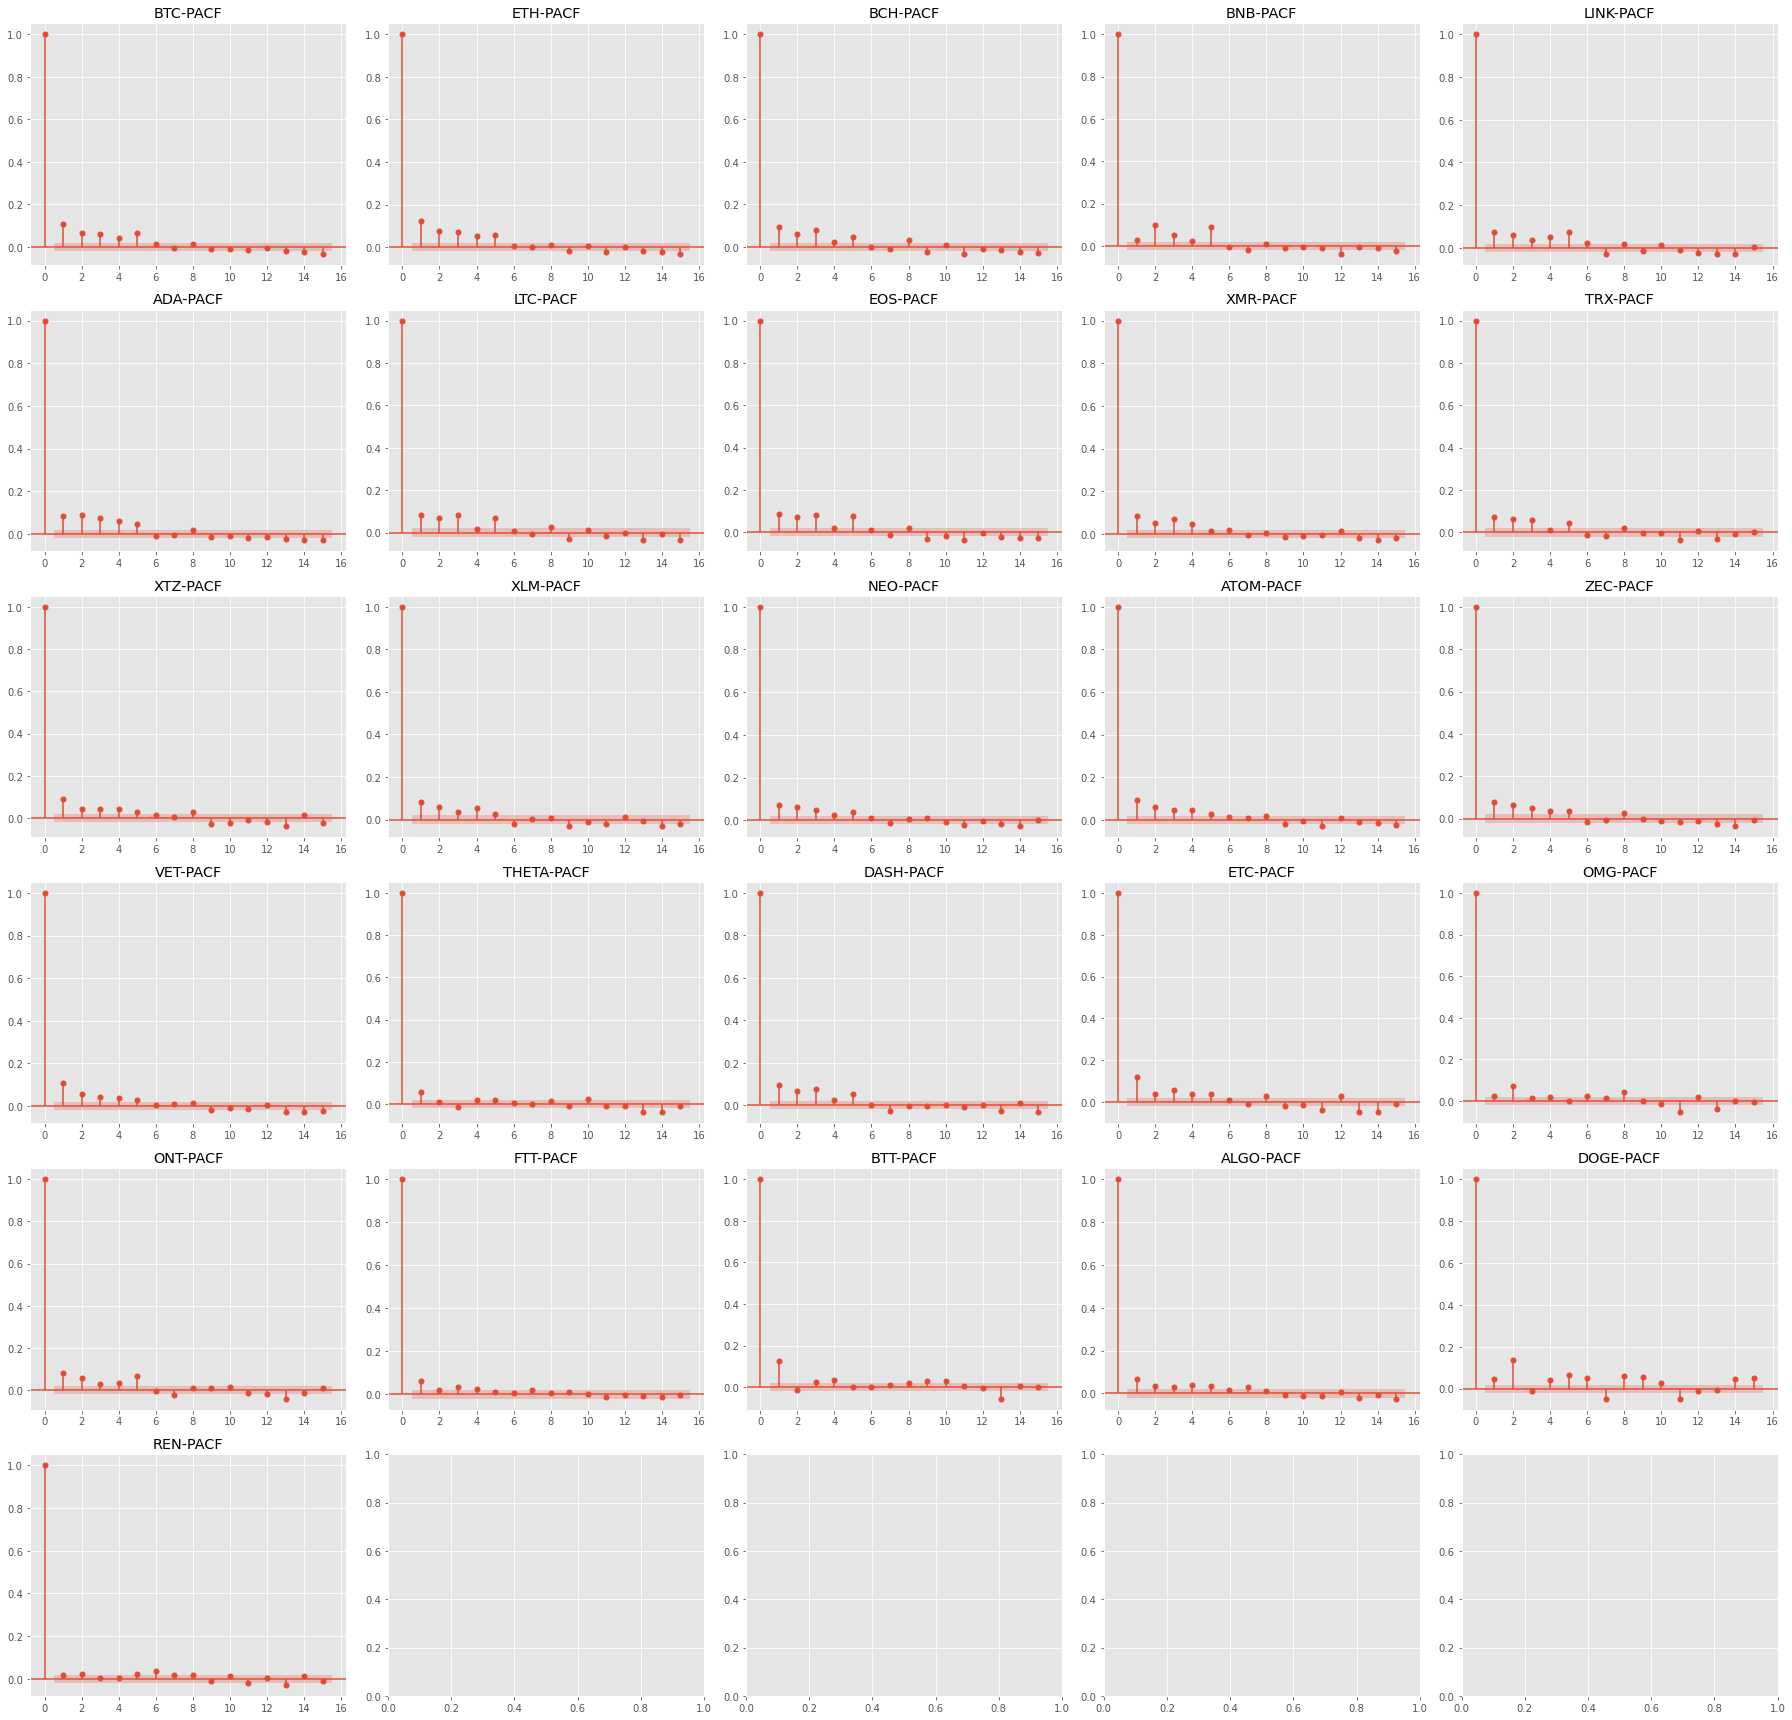

In [100]:
# Graph univariate Partial Autocorrelation Functions
fig, axs = plt.subplots(subplot_rows, 5, figsize=(25,subplot_rows * 4))
i, tscols = 0, ts_data.columns
for row in axs:
    for entry in row:
        if i >= len(tscols):
            break
        coin = tscols[i]
        plot_pacf(ts_data[coin], ax=entry, lags=15)
        entry.set_title("{}-PACF".format(coin))
        i += 1
plt.tight_layout()
plt.show()

#### Error Visualizing

In [101]:
from statsmodels.tools.eval_measures import rmse

def prediction_rmse_mape(preds):
    rmses, mapes = {}, {}
    for coin, residual in preds.items():
        y = test_ts[coin]
        yhat = preds[coin]
        yhat.index = y.index
        residual = y - yhat
        
        rmses[coin] = np.sqrt(np.mean(residual ** 2))
        
        mape = np.abs(residual / y)
        ind = np.where(mape == np.inf)[0]
        mape[ind] = -yhat[ind]
        mapes[coin] = np.mean(mape)

    return rmses, mapes

In [102]:
def plot_rmse_mape(rmses, mapes):

    fig, axs = plt.subplots(2, 1, figsize=(18, 8))
    axs[0].bar(list(rmses.keys()), list(rmses.values()), align='center')
    axs[1].bar(list(mapes.keys()), list(mapes.values()), align='center')
    axs[0].set_title("Residual Mean Squared Error")
    axs[1].set_title("Mean Absolute Percent Error")
    axs[1].plot(range(c), [1]*c, color='black', linestyle='--', lw=3)
    plt.show()

### Train / Test Segmentation

In [103]:
import sklearn
from sklearn.model_selection import train_test_split

train_ts, test_ts = train_test_split(ts_data, test_size=.2, shuffle=False)
print(f"train shape: [{train_ts.shape}], test shape: [{test_ts.shape}]")

train shape: [(8042, 26)], test shape: [(2011, 26)]


### AR(1)

In [104]:
out = '{3}\t|AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}|'
ARs = {}

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for coin, ts in train_ts.iteritems():
        ar = AutoReg(ts, lags = AR_LAGS).fit()
        print(out.format(ar.aic, ar.hqic, ar.bic, coin))
        ARs[coin] = ar

BTC	|AIC: -12.988, HQIC: -12.986, BIC: -12.982|
ETH	|AIC: -12.492, HQIC: -12.489, BIC: -12.485|
BCH	|AIC: -12.290, HQIC: -12.288, BIC: -12.284|
BNB	|AIC: -12.453, HQIC: -12.451, BIC: -12.447|
LINK	|AIC: -11.829, HQIC: -11.827, BIC: -11.823|
ADA	|AIC: -12.378, HQIC: -12.376, BIC: -12.372|
LTC	|AIC: -12.532, HQIC: -12.530, BIC: -12.526|
EOS	|AIC: -12.484, HQIC: -12.482, BIC: -12.478|
XMR	|AIC: -12.688, HQIC: -12.686, BIC: -12.682|
TRX	|AIC: -12.384, HQIC: -12.382, BIC: -12.378|
XTZ	|AIC: -11.928, HQIC: -11.926, BIC: -11.922|
XLM	|AIC: -12.540, HQIC: -12.538, BIC: -12.534|
NEO	|AIC: -12.293, HQIC: -12.291, BIC: -12.287|
ATOM	|AIC: -12.123, HQIC: -12.121, BIC: -12.117|
ZEC	|AIC: -12.404, HQIC: -12.402, BIC: -12.398|
VET	|AIC: -11.921, HQIC: -11.919, BIC: -11.915|
THETA	|AIC: -11.365, HQIC: -11.363, BIC: -11.359|
DASH	|AIC: -12.486, HQIC: -12.484, BIC: -12.480|
ETC	|AIC: -12.331, HQIC: -12.328, BIC: -12.324|
OMG	|AIC: -11.817, HQIC: -11.815, BIC: -11.811|
ONT	|AIC: -12.268, HQIC: -12.266, B

In [105]:
# Checking p-values
p_values_df = pd.DataFrame()
for coin, mod in ARs.items():
    p_values_df[coin] = mod.pvalues.values
new_index = ['Intercept']
for i in range(AR_LAGS):
    new_index.append(f"L{i+1}")
p_values_df.index = new_index
p_values_df

,BTC,ETH,BCH,BNB,LINK,ADA,LTC,EOS,XMR,TRX,...,THETA,DASH,ETC,OMG,ONT,FTT,BTT,ALGO,DOGE,REN
Intercept,3.331569e-01,3.398196e-01,7.607218e-01,7.586857e-01,2.471243e-01,2.079833e-01,7.626940e-01,3.613062e-01,2.025889e-01,9.105529e-01,...,6.296530e-01,4.786032e-01,8.182142e-01,1.091854e-02,2.699355e-01,0.846019,3.947591e-01,4.878468e-03,0.221843,0.020297
L1,2.617912e-09,1.045081e-21,8.218684e-17,9.659872e-01,3.411007e-08,1.425171e-11,1.444975e-08,1.605355e-06,8.689911e-11,2.512202e-06,...,4.618356e-07,1.115582e-12,5.004995e-23,2.029710e-01,2.406114e-06,0.000683,5.387249e-07,8.439140e-09,0.987935,0.296804
L2,1.105834e-05,1.460099e-08,2.401127e-06,7.346300e-20,1.727403e-07,2.074397e-10,5.586333e-06,6.162693e-12,7.469061e-07,9.848896e-09,...,4.434691e-01,5.699263e-09,1.154339e-03,5.396805e-11,1.530167e-11,0.238093,1.481215e-02,1.648899e-01,0.125657,0.460073
L3,9.263715e-11,7.536764e-10,3.123441e-16,5.600542e-06,1.141350e-01,7.938670e-09,2.538222e-19,1.215171e-16,3.816164e-08,2.298972e-04,...,5.463400e-03,1.220037e-10,5.805982e-08,6.648813e-01,3.515132e-01,0.008651,2.362339e-03,4.134106e-02,0.059466,0.433351
L4,2.551746e-05,1.090354e-03,2.086504e-01,2.825426e-01,4.936743e-06,1.645377e-04,6.888820e-01,1.615478e-02,2.303042e-02,3.389732e-02,...,8.693649e-02,2.157132e-01,2.868150e-02,6.891874e-01,2.144886e-04,0.158775,5.221146e-03,2.865547e-01,0.483708,0.459944
L5,2.551925e-10,3.406044e-10,6.730676e-07,3.118184e-12,1.178787e-09,1.151061e-05,2.189904e-13,9.610076e-17,5.225982e-01,3.111144e-09,...,2.487207e-01,5.372747e-05,5.430758e-05,4.715918e-02,4.087244e-13,0.643296,6.199751e-02,2.375579e-04,0.391326,0.264163


In [106]:
# Calculate everything
ar_preds = {}
ar_rets = {}
for coin, ts in test_ts.iteritems():
    
    # RMSE, MAPE calculations
    ar = ARs[coin]
    yhat = ar.model.predict(ar.params, start=0, end=len(ts) + (AR_LAGS - 1))
    ar_preds[coin] = yhat

    # Sharpe and cumulative return calculations
    signs = yhat.copy()
    signs.index = ts.index
    signs[signs > 0] = 1
    signs[signs < 0] = -1
    ar_rets[coin] = np.multiply(signs, ts)

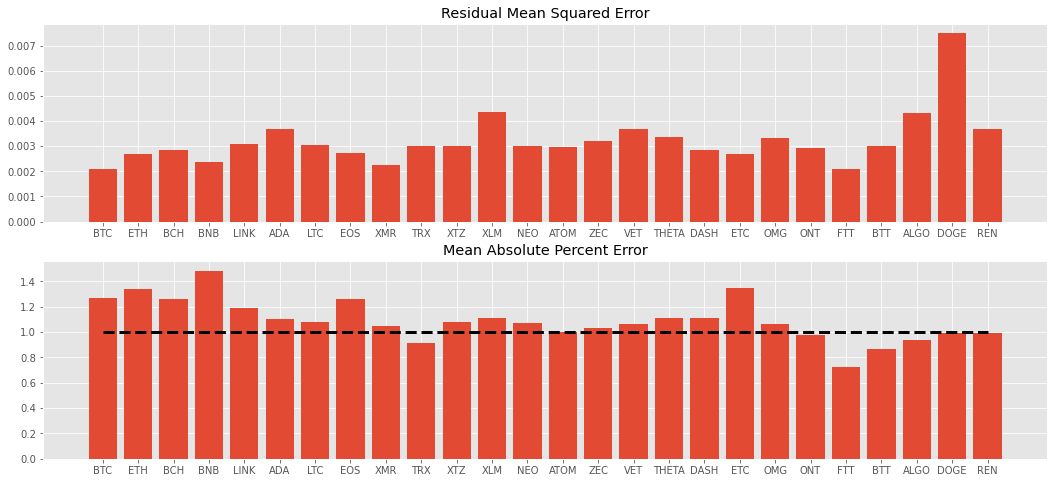

In [107]:
ar_rmses, ar_mapes = prediction_rmse_mape(ar_preds)
plot_rmse_mape(ar_rmses, ar_mapes)

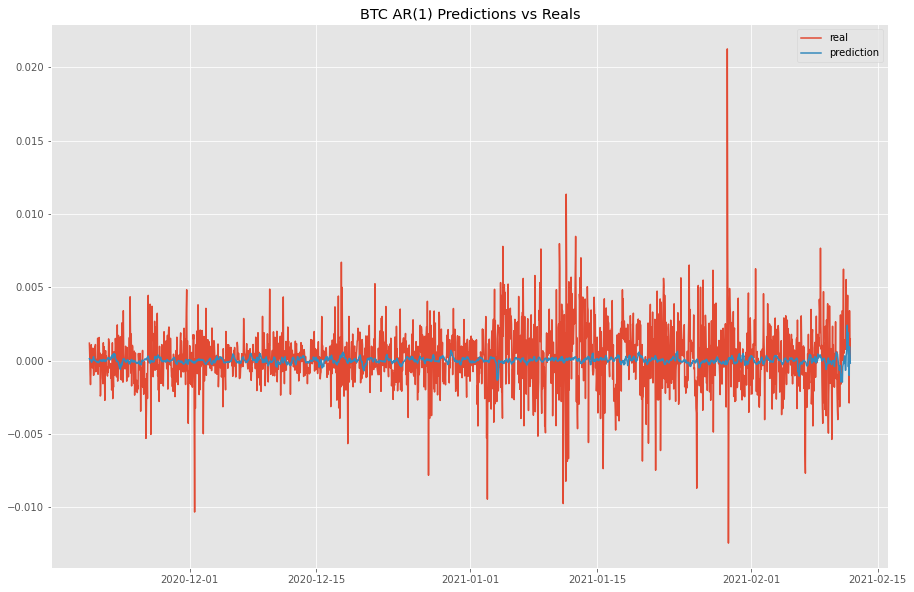

In [108]:
btc_y = test_ts['BTC']
btc_yhat = ar_preds['BTC']
btc_yhat.index = btc_y.index

fig = plt.figure(figsize=(15,10))
plt.plot(btc_y, label ='real')
plt.plot(btc_yhat, label ='prediction')
plt.title("BTC AR(1) Predictions vs Reals")
plt.legend()
plt.show()

BTC: 	-4.3%
ETH: 	26.7%
BCH: 	11.0%
BNB: 	9.2%
LINK: 	32.8%
ADA: 	52.7%
LTC: 	-5.2%
EOS: 	6.8%
XMR: 	0.6%
TRX: 	42.3%
XTZ: 	1.9%
XLM: 	50.1%
NEO: 	28.8%
ATOM: 	-8.4%
ZEC: 	43.0%
VET: 	17.1%
THETA: 	7.9%
DASH: 	15.5%
ETC: 	21.1%
OMG: 	22.0%
ONT: 	-4.8%
FTT: 	1.2%
BTT: 	-10.5%
ALGO: 	54.8%
DOGE: 	21.7%
REN: 	62.4%


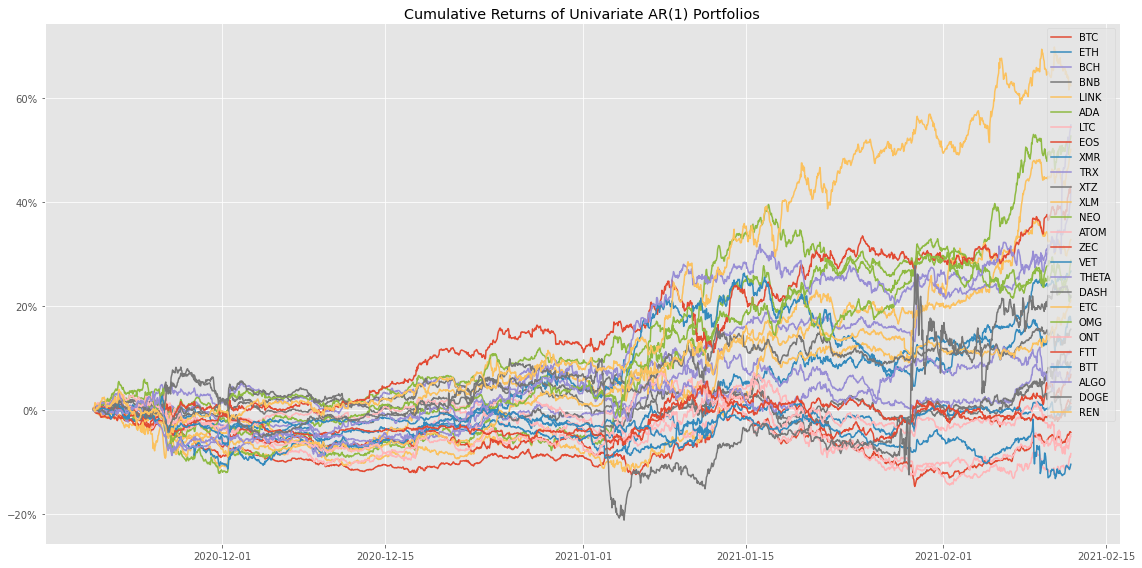

In [109]:
fig, ax = plt.subplots(figsize=(16,8))
for coin, strat_rets in ar_rets.items():
    
    # Handling outlier
#     if coin == "DOGE": continue
    
    cumret = (((strat_rets + 1).cumprod() - 1) * 100)
    plt.plot(cumret, label=coin)
    print(f'{coin}: \t{round(cumret[-1], 1)}%')
    

plt.title("Cumulative Returns of Univariate AR(1) Portfolios")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.tight_layout()
plt.show()

### ARMA(1,1)

In [110]:
out = '{3}\t|AIC: {0:0.3f}, HQIC: {1:0.3f}, BIC: {2:0.3f}|'
ARMAs = {}
order = (AR_LAGS, 0, AR_LAGS)       # (p = AR, I, q = MA)
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    for coin, ts in train_ts.iteritems():
        arma = ARIMA(ts, order = order).fit()
        print(out.format(arma.aic, arma.hqic, arma.bic, coin))
        ARMAs[coin] = arma

BTC	|AIC: -81624.481, HQIC: -81595.768, BIC: -81540.572|
ETH	|AIC: -77637.478, HQIC: -77608.765, BIC: -77553.569|
BCH	|AIC: -76018.762, HQIC: -75990.049, BIC: -75934.853|
BNB	|AIC: -77334.410, HQIC: -77305.696, BIC: -77250.500|
LINK	|AIC: -72299.616, HQIC: -72270.903, BIC: -72215.707|
ADA	|AIC: -76719.977, HQIC: -76691.263, BIC: -76636.067|
LTC	|AIC: -77963.157, HQIC: -77934.444, BIC: -77879.248|
EOS	|AIC: -77575.240, HQIC: -77546.527, BIC: -77491.331|
XMR	|AIC: -79210.152, HQIC: -79181.438, BIC: -79126.242|
TRX	|AIC: -76764.382, HQIC: -76735.669, BIC: -76680.473|
XTZ	|AIC: -73120.423, HQIC: -73091.709, BIC: -73036.513|
XLM	|AIC: -78033.405, HQIC: -78004.691, BIC: -77949.495|
NEO	|AIC: -76034.496, HQIC: -76005.783, BIC: -75950.587|
ATOM	|AIC: -74547.787, HQIC: -74519.074, BIC: -74463.878|
ZEC	|AIC: -76930.893, HQIC: -76902.179, BIC: -76846.983|
VET	|AIC: -73013.252, HQIC: -72984.539, BIC: -72929.343|
THETA	|AIC: -68532.980, HQIC: -68504.267, BIC: -68449.071|
DASH	|AIC: -77596.547, HQIC

In [111]:
arma_preds = {}
arma_rets = {}
for coin, ts in test_ts.iteritems():

    # RMSE, MAPE calculations
    arma = ARMAs[coin]
    yhat = arma.predict(start=0, end=len(ts) - 1)
    arma_preds[coin] = yhat
    
    # Sharpe and cumulative return calculations
    signs = yhat.copy()
    signs.index = ts.index
    signs[signs > 0] = 1
    signs[signs < 0] = -1
    arma_rets[coin] = np.multiply(signs, ts)

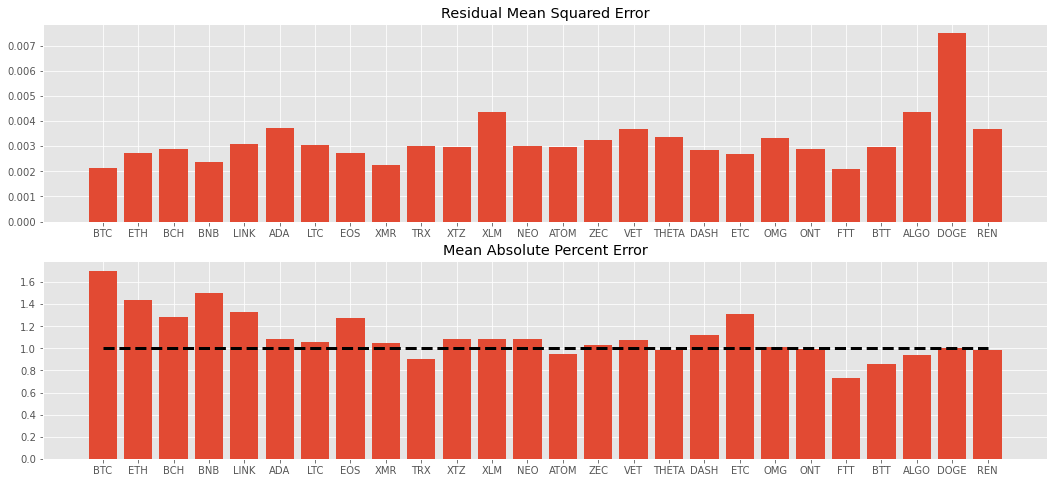

In [112]:
arma_rmses, arma_mapes = prediction_rmse_mape(arma_preds)
plot_rmse_mape(arma_rmses, arma_mapes)

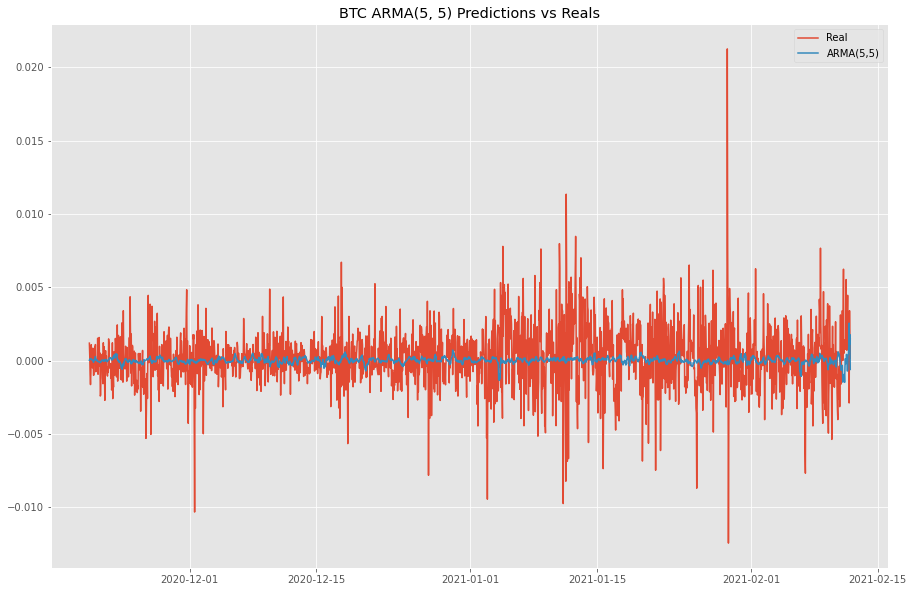

In [113]:
btc_y = test_ts['BTC']
btc_yhat = arma_preds['BTC']
btc_yhat.index = btc_y.index

fig = plt.figure(figsize=(15,10))
plt.plot(btc_y, label ='Real')
plt.plot(btc_yhat, label ='ARMA({},{})'.format(AR_LAGS, AR_LAGS))
plt.title("BTC ARMA({}, {}) Predictions vs Reals".format(AR_LAGS, AR_LAGS))
plt.legend()
plt.show()

BTC: 	-4.2%
ETH: 	2.3%
BCH: 	-8.5%
BNB: 	-14.8%
LINK: 	11.3%
ADA: 	29.7%
LTC: 	0.2%
EOS: 	11.7%
XMR: 	12.1%
TRX: 	0.0%
XTZ: 	22.8%
XLM: 	-11.0%
NEO: 	-3.7%
ATOM: 	28.6%
ZEC: 	2.4%
VET: 	-10.1%
THETA: 	30.1%
DASH: 	-1.8%
ETC: 	17.9%
OMG: 	59.7%
ONT: 	-5.9%
FTT: 	3.5%
BTT: 	45.1%
ALGO: 	25.4%
DOGE: 	142.4%
REN: 	86.7%


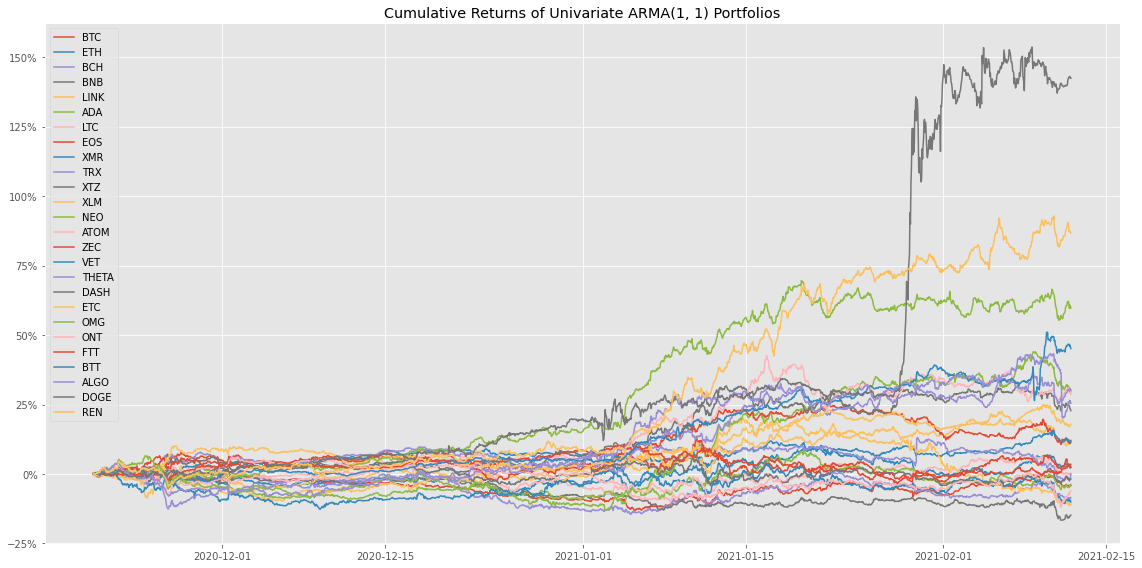

In [114]:
fig, ax = plt.subplots(figsize=(16,8))
for coin, strat_rets in arma_rets.items():
    cumret = (((strat_rets + 1).cumprod() - 1) * 100)
    plt.plot(cumret, label=coin)
    print(f'{coin}: \t{round(cumret[-1], 1)}%')
    

plt.title("Cumulative Returns of Univariate ARMA(1, 1) Portfolios")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.tight_layout()
plt.show()

#### Comparing AR, ARMA, Buy-And-Hold

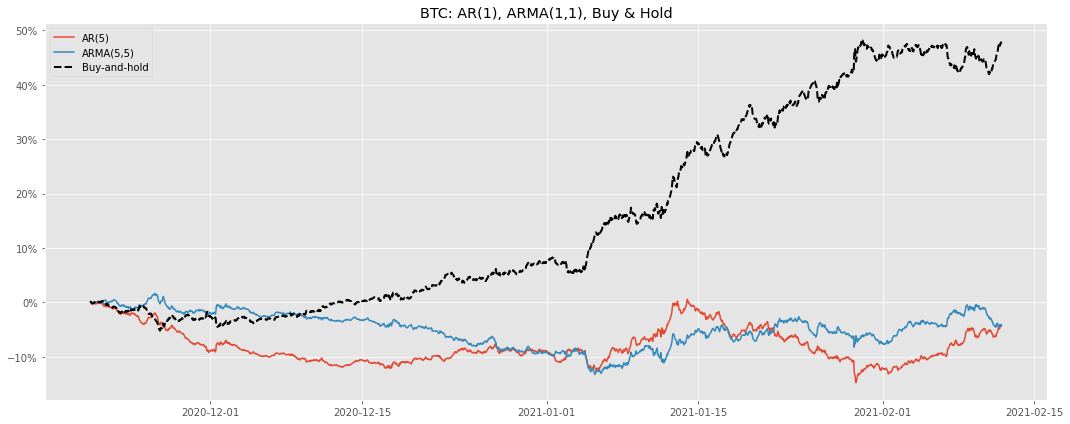

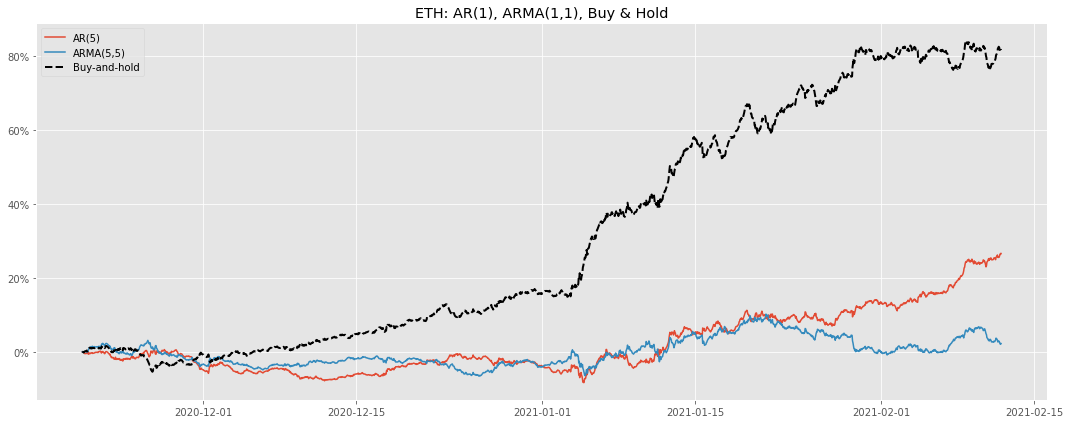

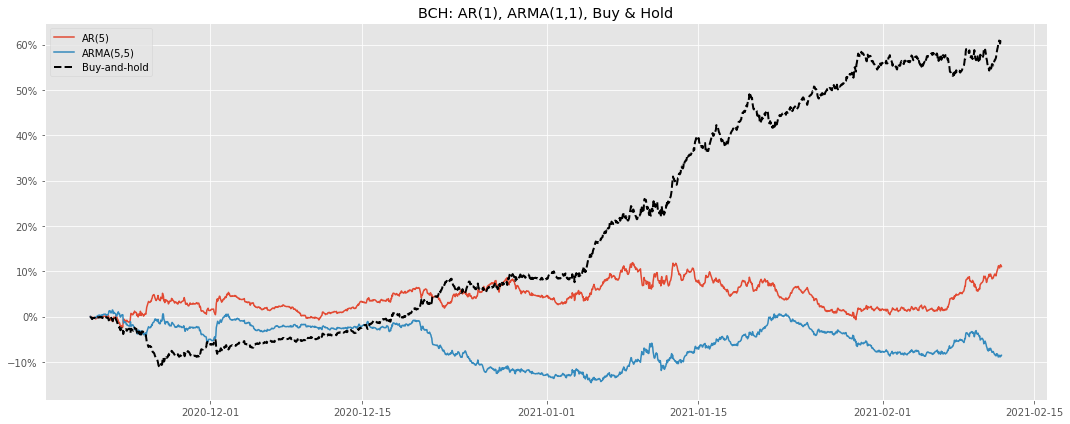

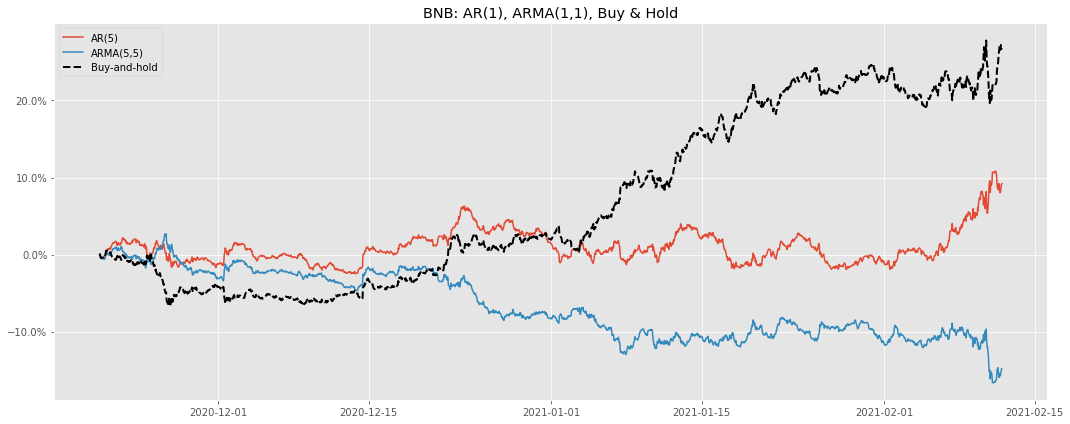

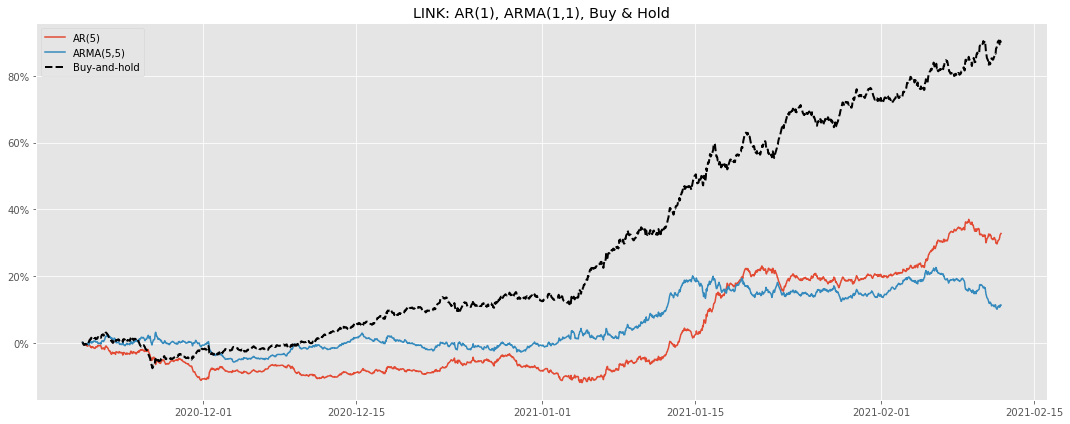

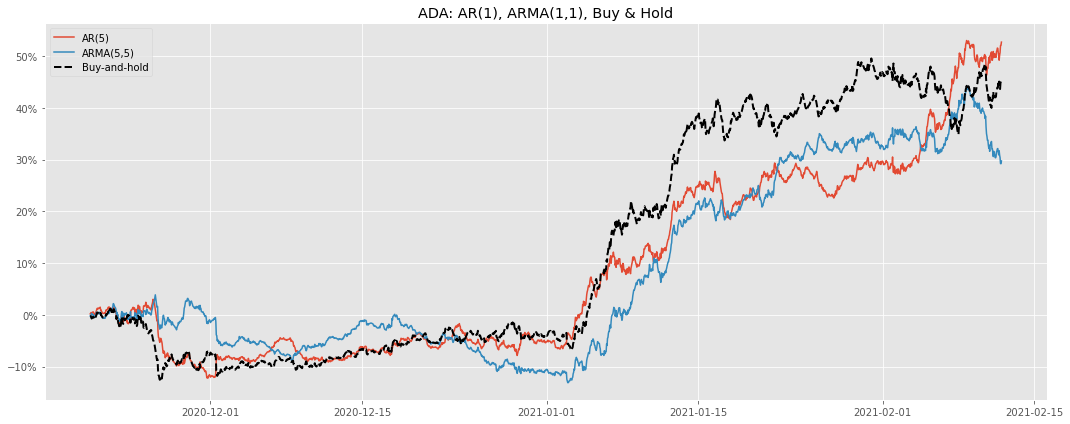

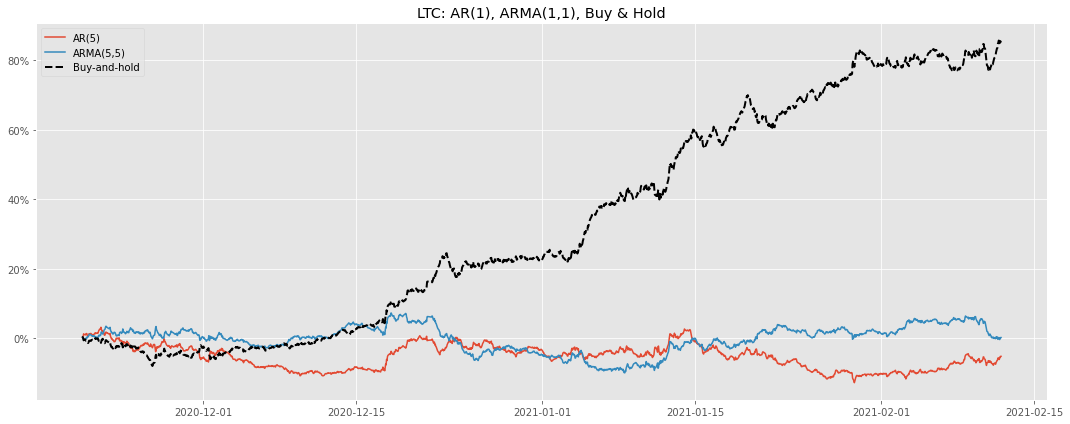

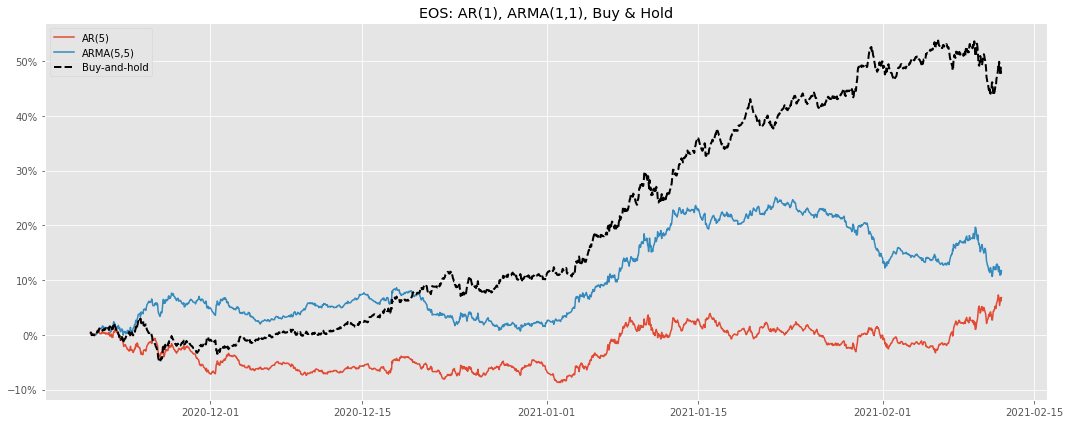

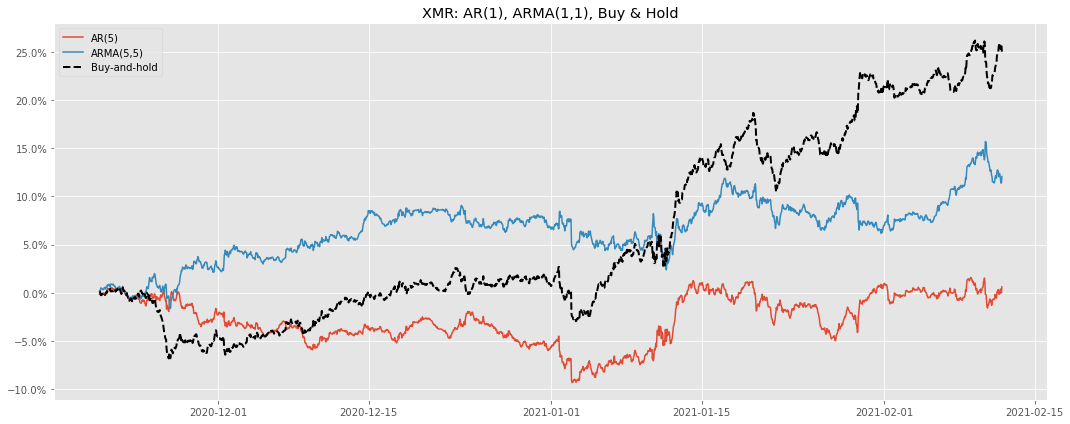

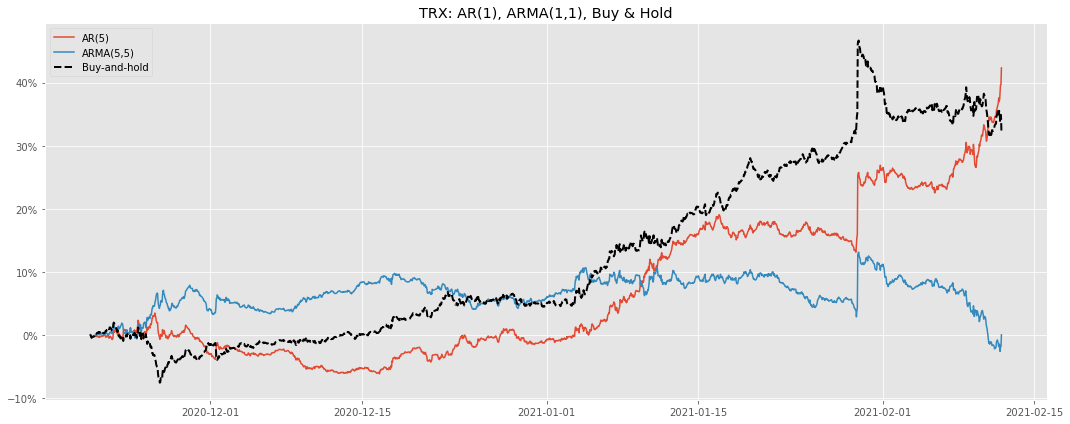

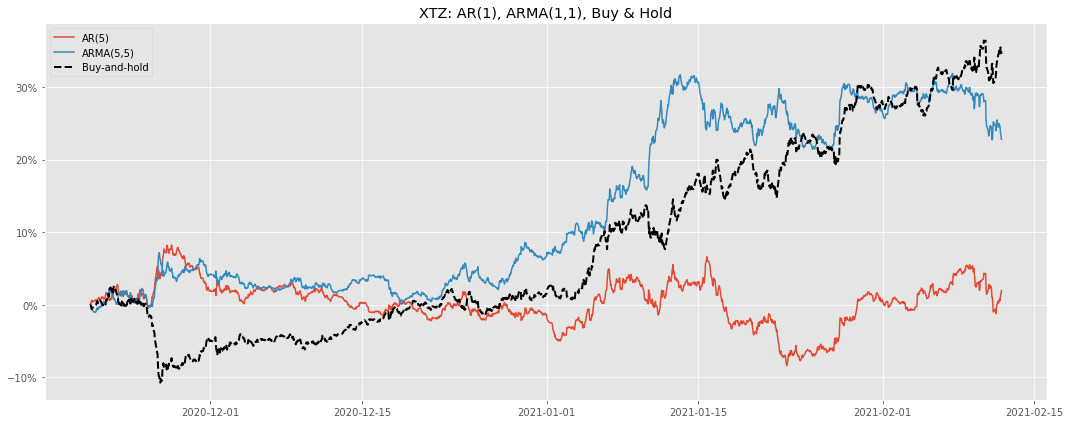

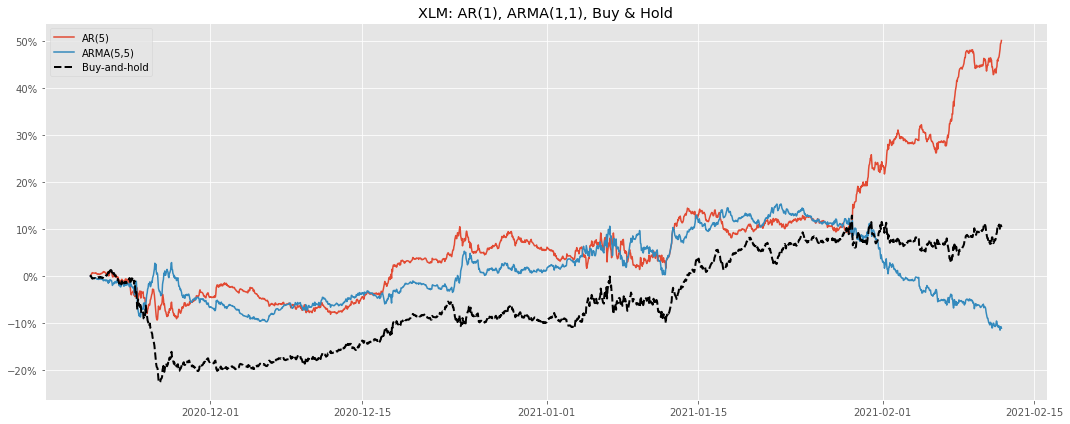

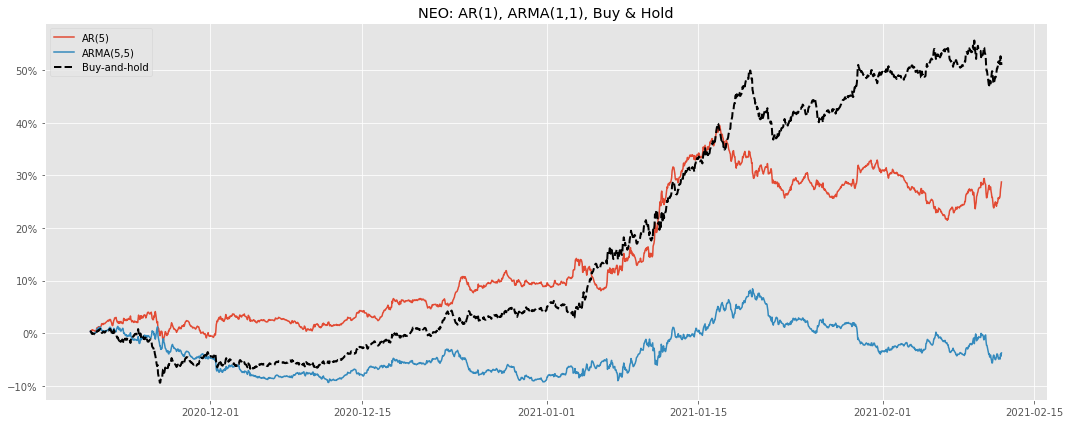

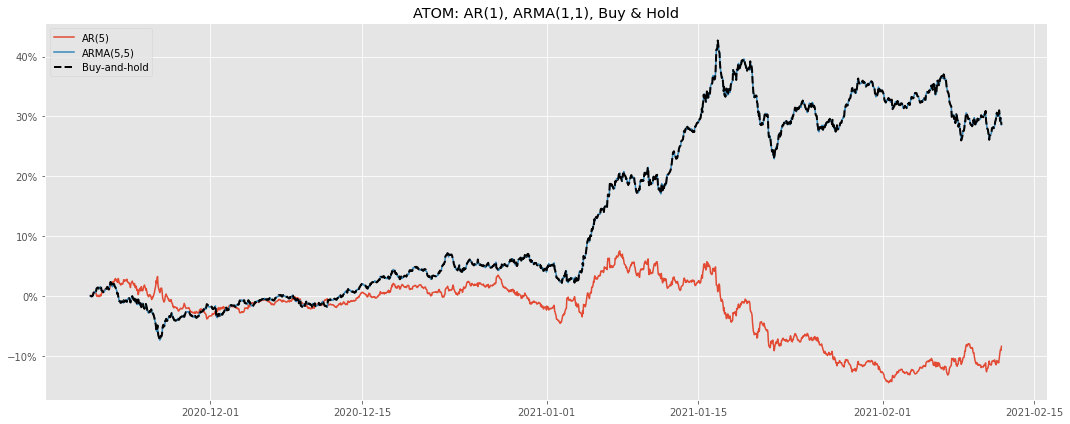

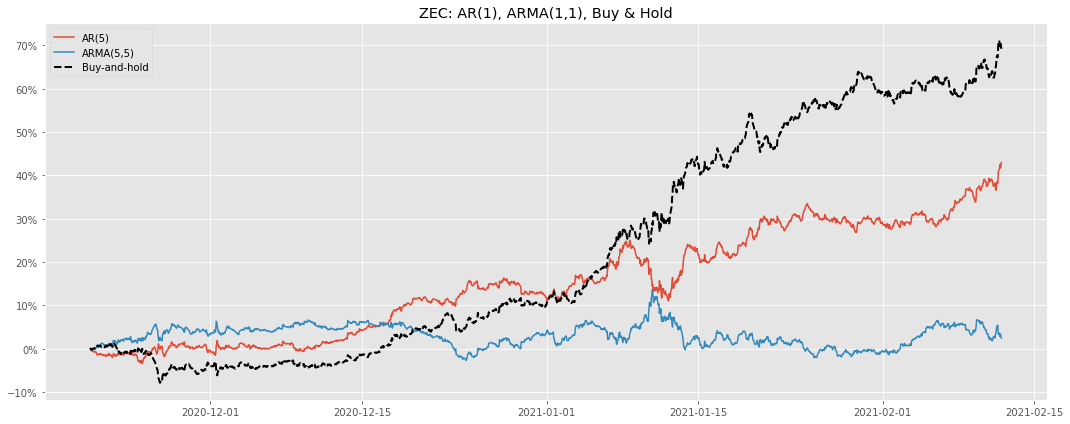

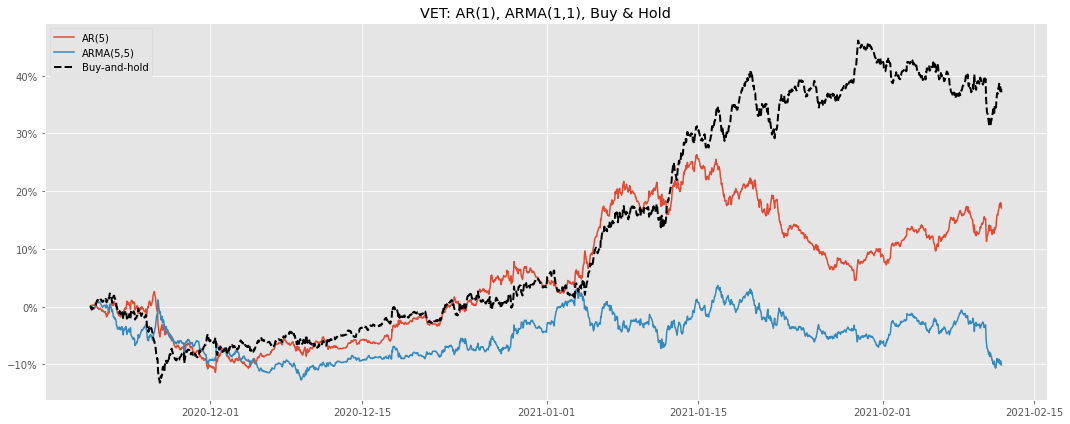

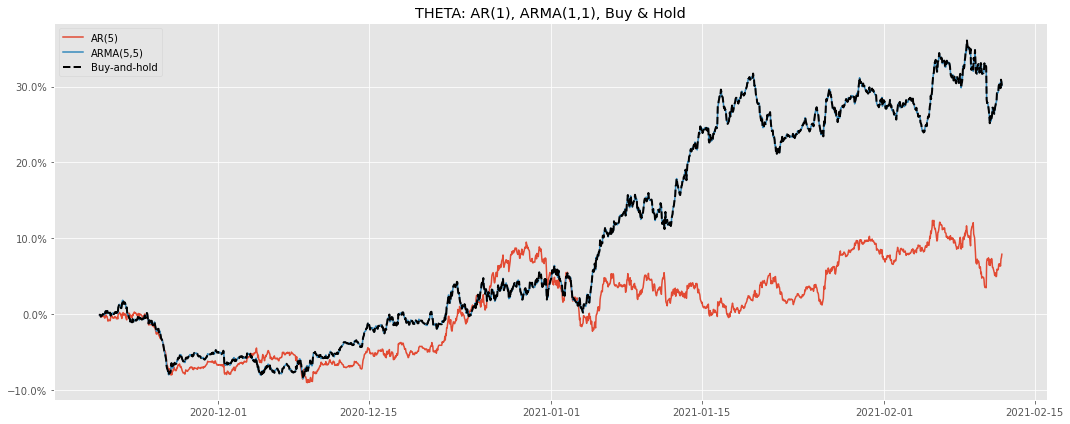

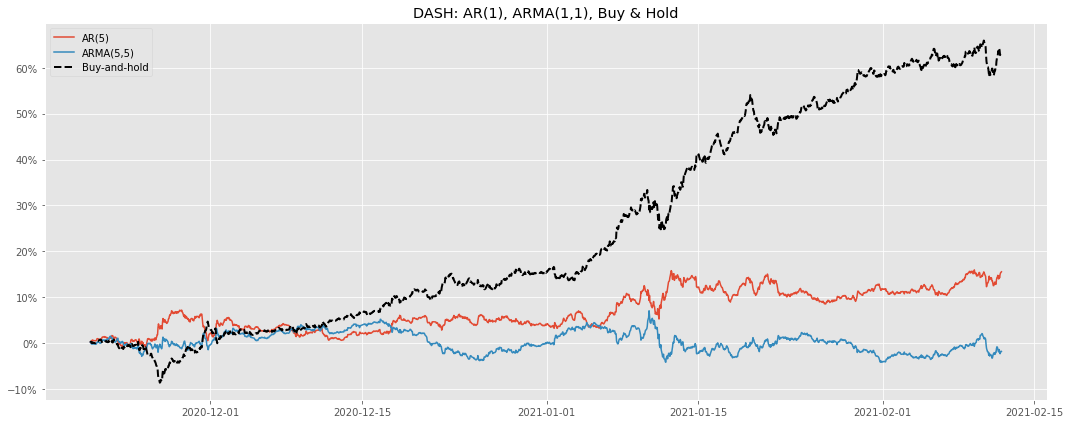

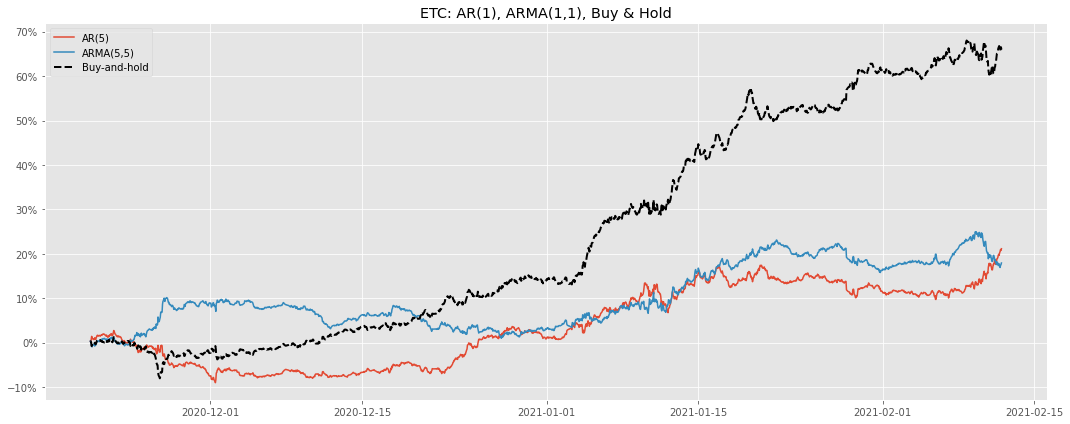

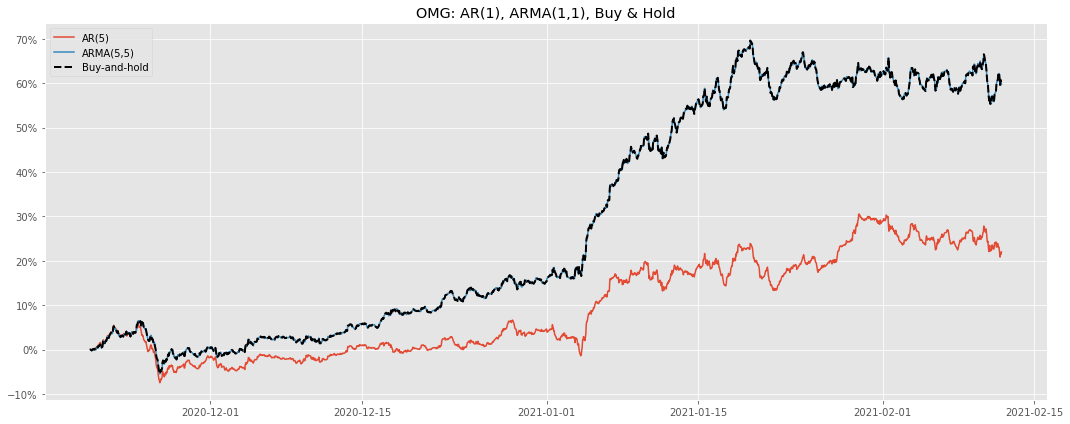

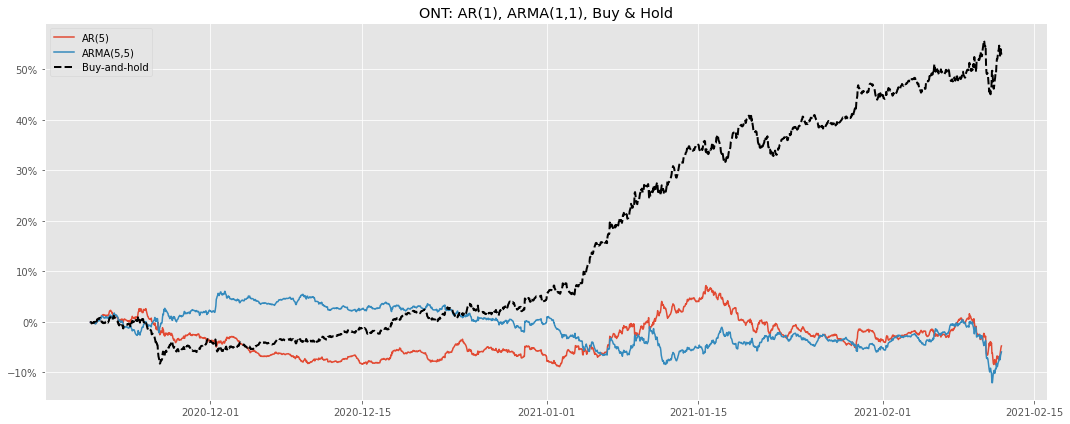

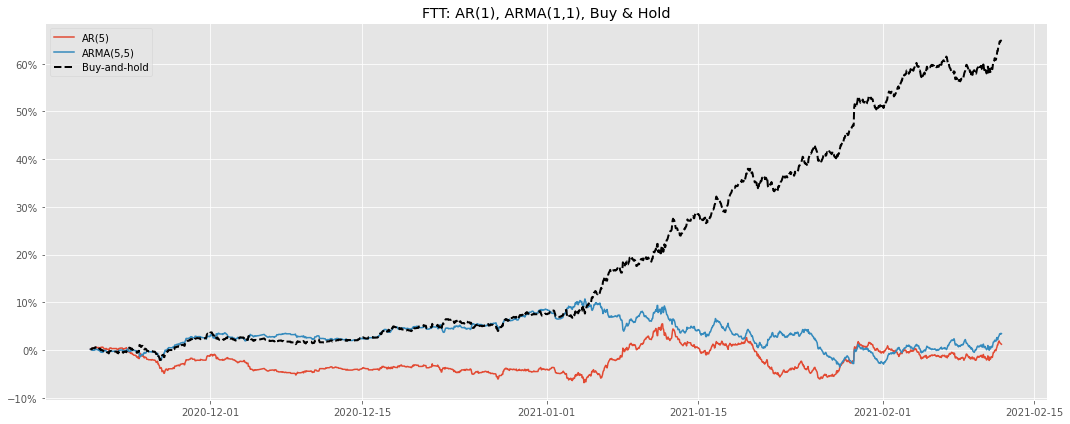

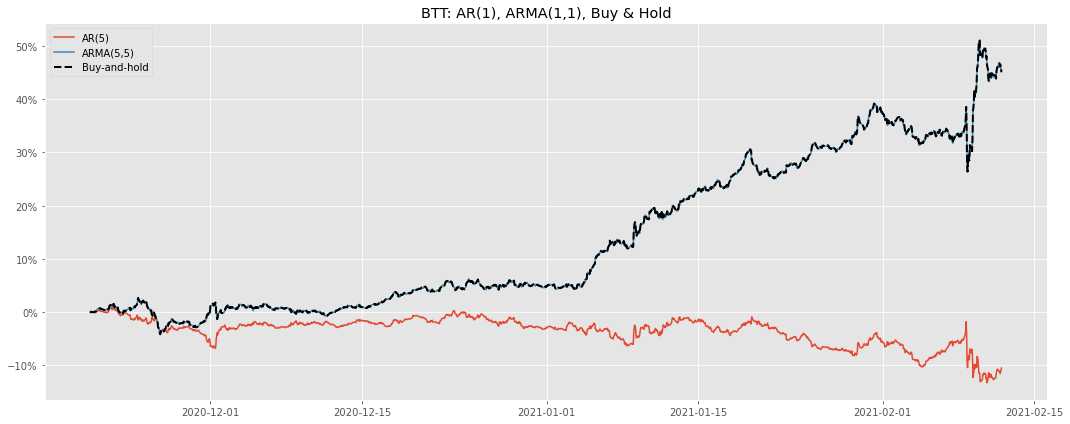

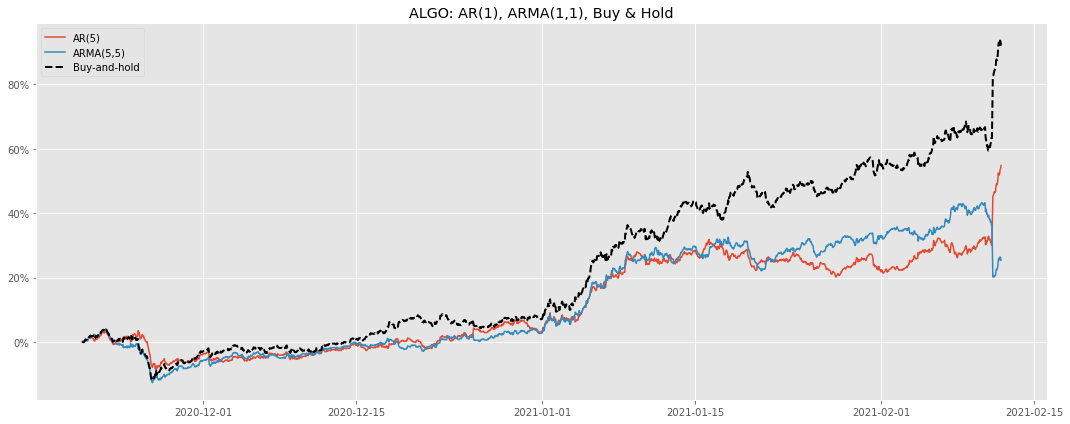

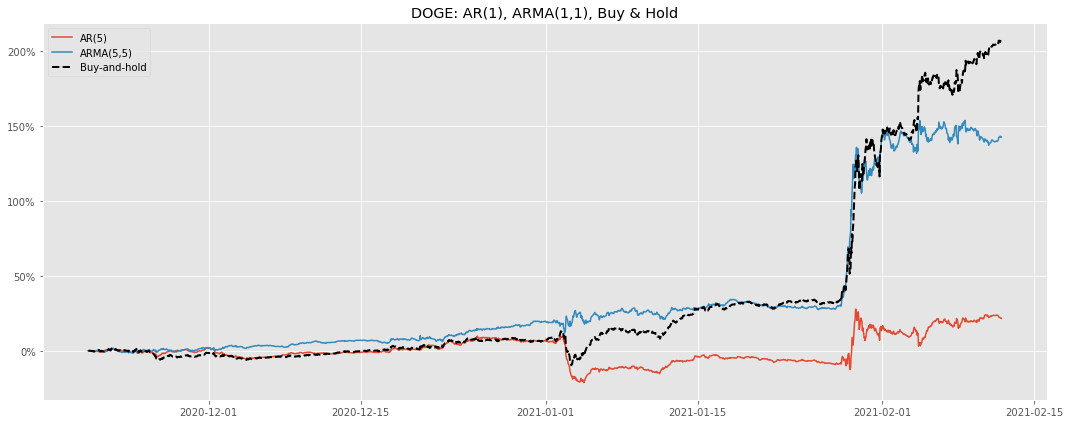

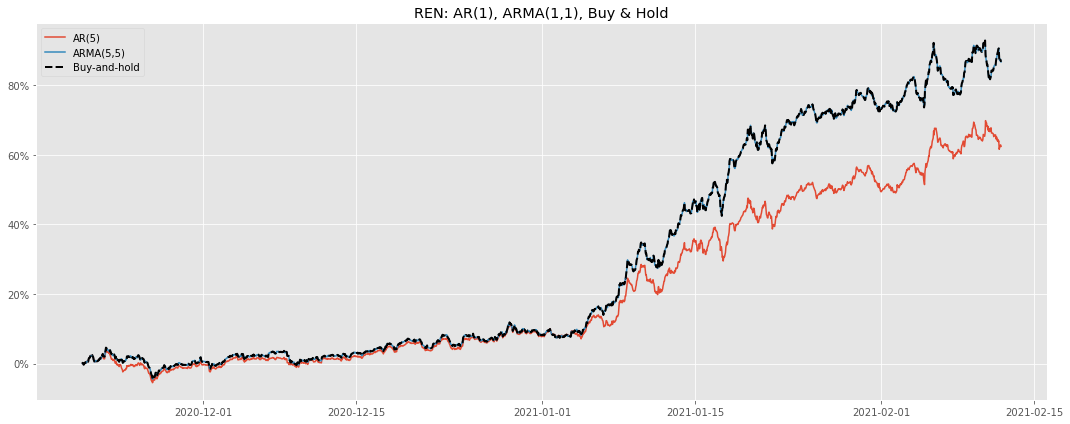

In [115]:
for coin in COIN_SUBSET:
    ar = ar_rets[coin]
    arma = arma_rets[coin]
    real = test_ts[coin]
    
    fig, ax = plt.subplots(figsize=(15,6))
    plt.plot((((ar + 1).cumprod() - 1) * 100), label="AR({})".format(AR_LAGS))
    plt.plot((((arma + 1).cumprod() - 1) * 100), label="ARMA({},{})".format(AR_LAGS, AR_LAGS))
    plt.plot((((real + 1).cumprod() - 1) * 100), label="Buy-and-hold",
             color='black', lw=2, linestyle='--')

    plt.title(f"{coin}: AR(1), ARMA(1,1), Buy & Hold")
    ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()
    plt.tight_layout()
    plt.show()

#### Sharpe ratios

In [116]:
def sharpe_ratio(return_series, N, rf):
    mean = return_series.mean() * N -rf
    sigma = return_series.std() * np.sqrt(N)
    return mean / sigma

ar_sharpes = {}
arma_sharpes = {}
for coin in COIN_SUBSET:
    ar_sharpes[coin] = sharpe_ratio(ar_rets[coin], 365 * 24, 0.1)
    arma_sharpes[coin] = sharpe_ratio(arma_rets[coin], 365 * 24, 0.1)

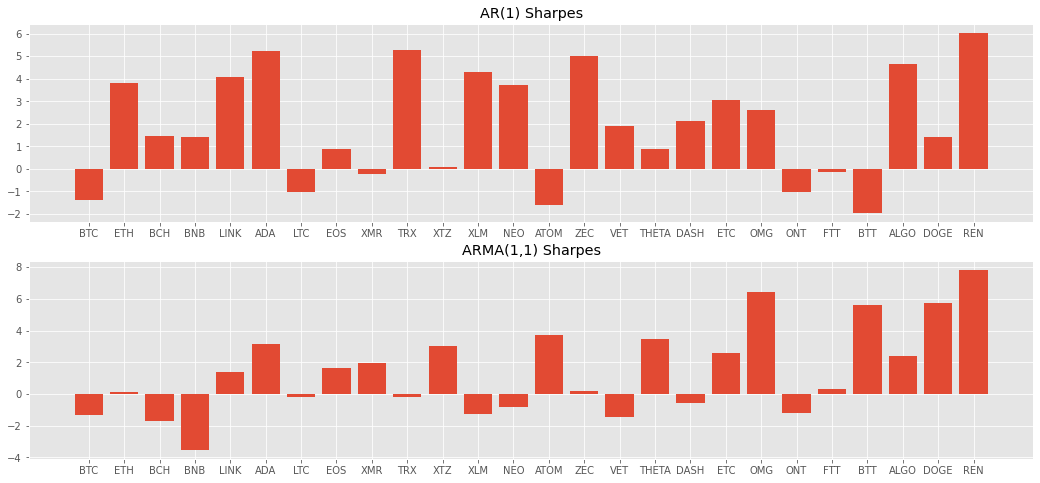

In [117]:
fig, axs = plt.subplots(2, 1, figsize=(18, 8))
axs[0].bar(list(ar_sharpes.keys()), list(ar_sharpes.values()), align='center')
axs[1].bar(list(arma_sharpes.keys()), list(arma_sharpes.values()), align='center')
axs[0].set_title("AR(1) Sharpes")
axs[1].set_title("ARMA(1,1) Sharpes")
plt.show()

---
## Deep Learning Models

###### Code based on [atcold/pytorch-deep-learning](https://github.com/Atcold/pytorch-Deep-Learning) on Github

#### Library imports

In [28]:
# standard 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")

# Pytorch
import torch
import torchvision
from torch import nn
import torch.nn.functional as fs

# Pretty
from IPython import display

### DATASET/DATALOADER PARAMETERS

In [29]:
lag = AR_LAGS
n_coins = len(COIN_SUBSET)
PARAMS = (returns,          # Returns df
          '1h',             # Resample Frequency
          AR_LAGS,          # AR Lag
          COIN_SUBSET)      # Coin subset
print(f'Input dimension: {lag * n_coins}')

Input dimension: 130


In [30]:
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms

class CryptoReturnsDataset(Dataset):

    def __init__(self, params, train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = torch.tensor(raw.iloc[lag : train_test_thresh].values)
        else:
            self.data = torch.tensor(raw.iloc[train_test_thresh :].values)
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        
    def __getitem__(self, index):
        x = self.data[index : index + self.lag]
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        y = self.data[index + self.lag].reshape(-1)
        return x, y

    def __len__(self):
        return self.n_samples

In [31]:
# crypto_transforms = transforms.Compose([
#     transforms.Resize(lag * len(subset)),
#     transforms.ToTensor()
# ])

######## Data loader ########
train_dataset = CryptoReturnsDataset(PARAMS, True)
test_dataset = CryptoReturnsDataset(PARAMS, False)

train_loader = DataLoader(train_dataset, batch_size = 64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=False)

######## Device ########
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cpu device


---
### Vanilla AutoEncoder
---

In [32]:
# Define standard AE model architecture and reconstruction loss

# ae_dim = 30   # for standard AE (under-complete hidden layer)
# ae_dim = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self, ae_dim = AR_LAGS):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(lag * n_coins, ae_dim),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(ae_dim, lag * n_coins),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

#### Training step

In [33]:
# (Hyper) parameter tuning
# epoch_jump = 50
# nepoch_jumps = 2
# epochs = np.arange(epoch_jump, 
#                   (epoch_jump * nepoch_jumps) + 1, 
#                    epoch_jump)
epochs = [500]
n_e = len(epochs)

# latent_dim_jump = 10
# nlatent_jumps = 2
# initial_latent = 10
# latent_dims = np.arange(initial_latent, 
#                         initial_latent + (nlatent_jumps * latent_dim_jump) + 1, 
#                         latent_dim_jump)
latent_dims = [LATENT_DIM]

n_models = n_e * len(latent_dims)
models = [0] * n_models

ae_losses = []
criterion = nn.MSELoss()
learning_rate = 1e-3

for j, ae_dim in enumerate(latent_dims):
    for i, num_epochs in enumerate(epochs):
        ######## Model instantiation ########
        model = Autoencoder(ae_dim).to(device)
        mod = (j * n_e) + i
        models[mod] = model

        ######## Configure the optimiser ########  
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
        )

        training_loss = np.zeros(num_epochs)
        for epoch in range(num_epochs):
            for i, data in enumerate(train_loader):
                x, _ = data
                x = x.to(device)
                x = x.view(x.size(0), -1)

                # =================== forward =====================
                output = model(x)  # feed <x> (for std AE) or <x_bad> (for denoising AE)
                loss = criterion(output, x.data)

                # =================== backward ====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # =================== log ========================
            print(f'model [{mod + 1}/{n_models}]: l_dim [{ae_dim}], epoch [{epoch+1}/{num_epochs}], loss: {loss.item():.9f}')
            display.clear_output(wait=True)

            # =================== record ========================
            training_loss[epoch] = loss.item()
        ae_losses.append(training_loss)

model [1/1]: l_dim [10], epoch [500/500], loss: 0.000001505


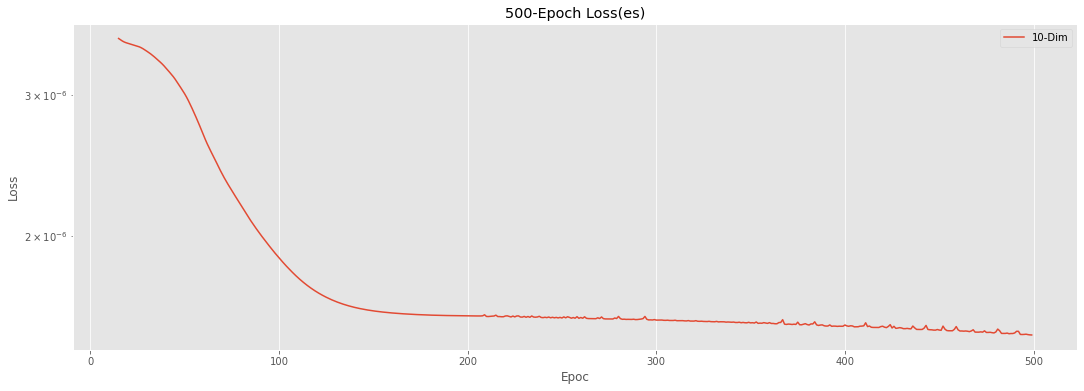

In [34]:
lookback = 485
def plot_model_losses(losses):
    fig=plt.figure(figsize=(18,6)) 
    for i, arr in enumerate(losses):
        ne = len(arr)
        ldim = latent_dims[i // n_e]
#         plt.plot(np.arange(ne-lookback, ne), arr[-lookback:], label=f'dim{ldim}|{ne}-epoch')
        plt.plot(np.arange(ne-lookback, ne), arr[-lookback:], label=f'{ldim}-Dim')
#         plt.plot(arr[4:], label=f'{ne}-Epoch')
#     plt.title(f"{len(losses[0])}-Jump Epoch Loss(es)")
    plt.title(f"{len(losses[0])}-Epoch Loss(es)")
    plt.legend()
    plt.grid(True)
    plt.yscale('log')
    plt.ylabel("Loss")
    plt.xlabel("Epoc")
    plt.show()

plot_model_losses(ae_losses)

#### Testing Steps

In [35]:
test_errors = []
errs = []
mags = np.ones(len(test_dataset))
for mod in range(n_models):
    model = models[mod]
    errors = np.ones(len(test_loader))
    for i, data in enumerate(test_loader):
        x, _ = data
        x = x.to(device)
        flat_x = x.view(x.size(0), -1)
        output = model(flat_x)
        errors[i] = torch.norm(output - flat_x, dim=1)
        if mod == 0:
            mags[i] = torch.norm(flat_x, dim=1)
    errs.append(errors)

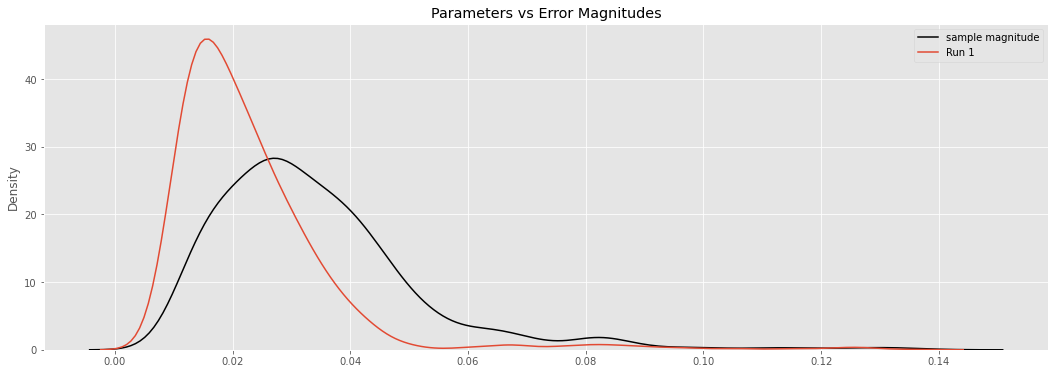

In [36]:
fig, ax = plt.subplots(figsize=(18,6))
bins = 100
sns.kdeplot(mags, label='sample magnitude', color="black")
for i, err in enumerate(errs):
    sns.kdeplot(err, ax=ax, label=f"Run {i+1}")
plt.grid(True)
plt.title("Parameters vs Error Magnitudes")
plt.legend()
plt.show()

#### Latent AE Dataset

In [37]:
errs = np.array(errs)
errmeans = errs.mean(axis=1)
best_index = np.where(errmeans == min(errmeans))[0][0]
best_ae = models[best_index]

In [54]:
class AELatentDataset(Dataset):

    def __init__(self, params = PARAMS, model = best_ae, train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = torch.tensor(raw.iloc[lag : train_test_thresh].values)
        else:
            self.data = torch.tensor(raw.iloc[train_test_thresh :].values)
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        self.ae = model
        
    def __getitem__(self, index):
        x = self.data[index : index + self.lag]
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        
        # Suggested syntax from torch warning
        latent_x = self.ae.encoder(x).clone().detach().requires_grad_(True) 
        
        y = self.data[index + self.lag].reshape(-1)
        return latent_x, y

    def __len__(self):
        return self.n_samples

######## Data loader ########
ae_latent_train_dataset = AELatentDataset(PARAMS, best_ae, train = True)
ae_latent_test_dataset = AELatentDataset(PARAMS, best_ae, train = False)

ae_latent_train_loader = DataLoader(ae_latent_train_dataset, 
                                    batch_size = 128, 
                                    shuffle=False)
ae_latent_test_loader = DataLoader(ae_latent_test_dataset,
                                   batch_size = 1,
                                   shuffle=False)

## PCA Datasets

`Confused about how to approach this`. Say our PCA fitting window, $w$, needs to be ~ `c = len(subset) = # coins`. Our AR Lags are represented by $l$. Do we compress the input sample $[x_{t-l},\dots,x_t]$ by...

$$T(x_t) = PCA.fit([x_{t-(l+w)}, x_{t-(l + w - 1)}, \dots, x_{t-(l + 1)}]).transform([x_{t - l}, \dots, x_t-1])$$

vs 

$$T(x_t) = PCA.fit\_transform([x_{t-(l + windodw)}, \dots, x_{t-1}, x_{t}]) \rightarrow\text{grab last $l$ rows only}$$

where $x_i\in\mathbb{R}^c$

In [ ]:
PCA(n_components = 2).fit_transform(sample)
# sample \in [1, 26]

In [120]:
from sklearn.decomposition import PCA, KernelPCA

class PCDataset(Dataset):

    def __init__(self, params = PARAMS, model = PCA(2), train = True):

        # unpack extensiblee input tuple 
        ts, resample_period, lag, subset = params
        self.window = len(subset)

        raw = simplify(ts[subset], resample_period).dropna(0, 'any')
        train_test_thresh = round((raw.shape[0] - lag) * .8) + lag
        if train:
            self.data = raw.iloc[lag : train_test_thresh].values
        else:
            self.data = raw.iloc[train_test_thresh :].values
    
        self.n_samples = self.data.shape[0] - lag
        self.lag = lag
        self.model = model
        
    def __getitem__(self, index):
        fitting = self.data
        x = self.data[index : index + self.lag]
        print(x.shape)
        d = x.shape[1]
        x = x.reshape(-1, self.lag * d)
        print(x.shape)
        
        latent_x = torch.tensor(self.model.fit_transform(x)) # CURRENTLY GOING WITH APPROACH 2
        y = self.data[index + self.lag].reshape(-1)
        return latent_x, y

    def __len__(self):
        return self.n_samples

######## LINEAR PCA Data loader ########
pca_train_dataset = PCDataset(PARAMS, PCA(LATENT_DIM), train = True)
pca_test_dataset  = PCDataset(PARAMS, PCA(LATENT_DIM), train = False)

pca_train_loader = DataLoader(pca_train_dataset, 
                                    batch_size = 128, 
                                    shuffle=False)
pca_test_loader = DataLoader(pca_test_dataset,
                                   batch_size = 1,
                                   shuffle=False)


######## NONLINEAR PCA Data loader ########
nlpca_train_dataset = PCDataset(PARAMS, KernelPCA(LATENT_DIM), train = True)
nlpca_test_dataset  = PCDataset(PARAMS, KernelPCA(LATENT_DIM), train = False)

nlpca_train_loader = DataLoader(nlpca_train_dataset, 
                                    batch_size = 128, 
                                    shuffle=False)
nlpca_test_loader = DataLoader(nlpca_test_dataset,
                                   batch_size = 1,
                                   shuffle=False)

In [121]:
######## AE Latent Dataset ########
ae_latent_train_dataset, ae_latent_test_dataset
ae_latent_train_loader, ae_latent_test_loader

######## PCA Latent Dataset ########
pca_train_dataset, pca_test_dataset
pca_train_loader, pca_test_loader

######## PCA Latent Dataset ########
nlpca_train_dataset, nlpca_test_dataset
nlpca_train_loader, nlpca_test_loader

# Made it through?
print("Nice")

Nice



## Predictive Models

In [70]:
import warnings
# warnings.filterwarnings("UserWarning")

# LSTM 
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.lstm = torch.nn.LSTM(input_size, hidden_size, batch_first=True)
        self.linear = torch.nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h = self.lstm(x)[0]
        x = self.linear(h)
        return x
    
    def get_states_across_time(self, x):
        h_c = None
        h_list, c_list = list(), list()
        with torch.no_grad():
            for t in range(x.size(1)):
                h_c = self.lstm(x[:, [t], :], h_c)[1]
                h_list.append(h_c[0])
                c_list.append(h_c[1])
            h = torch.cat(h_list)
            c = torch.cat(c_list)
        return h, c

def train(model, train_data_gen, criterion, optimizer, device):
    # Set the model to training mode. This will turn on layers that would
    # otherwise behave differently during evaluation, such as dropout.
    model.train()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # Iterate over every batch of sequences. Note that the length of a data generator
    # is defined as the number of batches required to produce a total of roughly 1000
    # sequences given a batch size.
    for data, target in train_data_gen:

        # Request a batch of sequences and class labels, convert them into tensors
        # of the correct type, and then send them to the appropriate device.
        data, target = data.float().to(device), target.float().to(device)

        # Perform the forward pass of the model
        output = model(data)  # Step ①

        # Pick only the output corresponding to last sequence element (input is pre padded)
        output = output[:, -1, :]

        # Compute the value of the loss for this batch. For loss functions like CrossEntropyLoss,
        # the second argument is actually expected to be a tensor of class indices rather than
        # one-hot encoded class labels. One approach is to take advantage of the one-hot encoding
        # of the target and call argmax along its second dimension to create a tensor of shape
        # (batch_size) containing the index of the class label that was hot for each sequence.
        loss = criterion(output, target)  # Step ②

        # Clear the gradient buffers of the optimized parameters.
        # Otherwise, gradients from the previous batch would be accumulated.
        optimizer.zero_grad()  # Step ③

        loss.backward()  # Step ④

        optimizer.step()  # Step ⑤

        y_pred = output.argmax(dim=1)
        num_correct += (y_pred == target).sum().item()

    return num_correct, loss.item() 

def test(model, test_data_gen, criterion, device):
    # Set the model to evaluation mode. This will turn off layers that would
    # otherwise behave differently during training, such as dropout.
    model.eval()

    # Store the number of sequences that were classified correctly
    num_correct = 0

    # A context manager is used to disable gradient calculations during inference
    # to reduce memory usage, as we typically don't need the gradients at this point.
    with torch.no_grad():
        for data, target in test_data_gen:
            data, target = torch.tensor(data).float().to(device), torch.tensor(target).float().to(device)

            output = model(data)
            # Pick only the output corresponding to last sequence element (input is pre padded)
            output = output[:, -1, :]

            loss = criterion(output, target)
            num_correct += (output == target).sum().item()

    return num_correct, loss.item()

def train_and_test(model, train_data_gen, test_data_gen, criterion, optimizer, max_epochs, verbose=True):
    # Automatically determine the device that PyTorch should use for computation
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # Move model to the device which will be used for train and test
    model.to(device)

    # Track the value of the loss function and model accuracy across epochs
    history_train = {'loss': [], 'acc': []}
    history_test = {'loss': [], 'acc': []}

    for epoch in range(max_epochs):
        # Run the training loop and calculate the accuracy.
        # Remember that the length of a data generator is the number of batches,
        # so we multiply it by the batch size to recover the total number of sequences.
        num_correct, loss = train(model, train_data_gen, criterion, optimizer, device)
        accuracy = float(num_correct) / (len(train_data_gen) * train_data_gen.batch_size) * 100
        history_train['loss'].append(loss)
        history_train['acc'].append(accuracy)

        # Do the same for the testing loop
        num_correct, loss = test(model, test_data_gen, criterion, device)
        accuracy = float(num_correct) / (len(test_data_gen) * test_data_gen.batch_size) * 100
        history_test['loss'].append(loss)
        history_test['acc'].append(accuracy)

        if verbose or epoch + 1 == max_epochs:
            print(f'[Epoch {epoch + 1}/{max_epochs}]'
                  f" loss: {history_train['loss'][-1]:.4f}, acc: {history_train['acc'][-1]:2.2f}%"
                  f" - test_loss: {history_test['loss'][-1]:.4f}, test_acc: {history_test['acc'][-1]:2.2f}%")

    # Generate diagnostic plots for the loss and accuracy
    fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
    for ax, metric in zip(axes, ['loss', 'acc']):
        ax.plot(history_train[metric])
        ax.plot(history_test[metric])
        ax.set_xlabel('epoch', fontsize=12)
        ax.set_ylabel(metric, fontsize=12)
        ax.legend(['Train', 'Test'], loc='best')
    plt.show()

    return model

In [71]:
# Setup the RNN and training settings
input_size  = LATENT_DIM
hidden_size = 4
output_size = n_coins
model       = SimpleLSTM(input_size, hidden_size, output_size)
criterion   = torch.nn.MSELoss()
optimizer   = torch.optim.RMSprop(model.parameters(), lr=0.001)
max_epochs  = 4

print(input_size, hidden_size, output_size)

10 4 26


In [122]:
# # Training & Testing with AutoEncoder Inputs
pca_LSTM = train_and_test(model, pca_train_loader, 
                          pca_test_loader, criterion, 
                          optimizer, max_epochs)

(5, 26)
(1, 130)


ValueError: n_components=10 must be between 0 and min(n_samples, n_features)=1 with svd_solver='full'

In [73]:
# # Training & Testing with AutoEncoder Inputs
# nlpca_LSTM = train_and_test(model, nlpca_train_loader, 
#                             nlpca_test_loader, criterion, 
#                             optimizer, max_epochs)

In [74]:
# Training & Testing with AutoEncoder Inputs
ae_LSTM = train_and_test(model, ae_latent_train_loader, 
                         ae_latent_test_loader, criterion, 
                         optimizer, max_epochs)

RuntimeError: The size of tensor a (128) must match the size of tensor b (26) at non-singleton dimension 1

----
## Transformer Model

In [ ]:
print "NOT IMPLEMENTED"

##### Multi-head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, p, d_input=None):
        super().__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        if d_input is None:
            d_xq = d_xk = d_xv = d_model
        else:
            d_xq, d_xk, d_xv = d_input
            
        # Make sure that the embedding dimension of model is a multiple of number of heads
        assert d_model % self.num_heads == 0

        self.d_k = d_model // self.num_heads
        
        # These are still of dimension d_model. They will be split into number of heads 
        self.W_q = nn.Linear(d_xq, d_model, bias=False)
        self.W_k = nn.Linear(d_xk, d_model, bias=False)
        self.W_v = nn.Linear(d_xv, d_model, bias=False)
        
        # Outputs of all sub-layers need to be of dimension d_model
        self.W_h = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V):
        batch_size = Q.size(0) 
        k_length = K.size(-2) 
        
        # Scaling by d_k so that the soft(arg)max doesnt saturate
        Q = Q / np.sqrt(self.d_k)                         # (bs, n_heads, q_length, dim_per_head)
        scores = torch.matmul(Q, K.transpose(2,3))          # (bs, n_heads, q_length, k_length)
        
        A = nn_Softargmax(dim=-1)(scores)   # (bs, n_heads, q_length, k_length)
        
        # Get the weighted average of the values
        H = torch.matmul(A, V)     # (bs, n_heads, q_length, dim_per_head)

        return H, A 

        
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (heads X depth)
        Return after transpose to put in shape (batch_size X num_heads X seq_length X d_k)
        """
        return x.view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)

    def group_heads(self, x, batch_size):
        """
        Combine the heads again to get (batch_size X seq_length X (num_heads times d_k))
        """
        return x.transpose(1, 2).contiguous().view(batch_size, -1, self.num_heads * self.d_k)
    

    def forward(self, X_q, X_k, X_v):
        batch_size, seq_length, dim = X_q.size()

        # After transforming, split into num_heads 
        Q = self.split_heads(self.W_q(X_q), batch_size)  # (bs, n_heads, q_length, dim_per_head)
        K = self.split_heads(self.W_k(X_k), batch_size)  # (bs, n_heads, k_length, dim_per_head)
        V = self.split_heads(self.W_v(X_v), batch_size)  # (bs, n_heads, v_length, dim_per_head)
        
        # Calculate the attention weights for each of the heads
        H_cat, A = self.scaled_dot_product_attention(Q, K, V)
        
        # Put all the heads back together by concat
        H_cat = self.group_heads(H_cat, batch_size)    # (bs, q_length, dim)
        
        # Final linear layer  
        H = self.W_h(H_cat)          # (bs, q_length, dim)
        
        return H, A

##### Convolutional Layer

In [ ]:
class CNN(nn.Module):
    def __init__(self, d_model, hidden_dim, p):
        super().__init__()
        self.k1convL1 = nn.Linear(d_model,    hidden_dim)
        self.k1convL2 = nn.Linear(hidden_dim, d_model)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.k1convL1(x)
        x = self.activation(x)
        x = self.k1convL2(x)
        return x

##### Transformer Encoder

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, conv_hidden_dim, p=0.1):
        super().__init__()

        self.mha = MultiHeadAttention(d_model, num_heads, p)
        self.cnn = CNN(d_model, conv_hidden_dim, p)

        self.layernorm1 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
        self.layernorm2 = nn.LayerNorm(normalized_shape=d_model, eps=1e-6)
    
    def forward(self, x):
        
        # Multi-head attention 
        attn_output, _ = self.mha(x, x, x)  # (batch_size, input_seq_len, d_model)
        
        # Layer norm after adding the residual connection 
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
        
        # Feed forward 
        cnn_output = self.cnn(out1)  # (batch_size, input_seq_len, d_model)
        
        #Second layer norm after adding residual connection 
        out2 = self.layernorm2(out1 + cnn_output)  # (batch_size, input_seq_len, d_model)

        return out2

Blocks of N Encoder Layers + Positional encoding + Input embedding

Self attention by itself does not have any recurrence or convolutions so to make it sensitive to position we must provide additional positional encodings. These are calculated as follows:

In [ ]:
def create_sinusoidal_embeddings(nb_p, dim, E):
    theta = np.array([
        [p / np.power(10000, 2 * (j // 2) / dim) for j in range(dim)]
        for p in range(nb_p)
    ])
    E[:, 0::2] = torch.FloatTensor(np.sin(theta[:, 0::2]))
    E[:, 1::2] = torch.FloatTensor(np.cos(theta[:, 1::2]))
    E.detach_()
    E.requires_grad = False
    E = E.to(device)

class Embeddings(nn.Module):
    def __init__(self, d_model, vocab_size, max_position_embeddings, p):
        super().__init__()
        self.word_embeddings = nn.Embedding(vocab_size, d_model, padding_idx=1)
        self.position_embeddings = nn.Embedding(max_position_embeddings, d_model)
        create_sinusoidal_embeddings(
            nb_p=max_position_embeddings,
            dim=d_model,
            E=self.position_embeddings.weight
        )

        self.LayerNorm = nn.LayerNorm(d_model, eps=1e-12)

    def forward(self, input_ids):
        seq_length = input_ids.size(1)
        position_ids = torch.arange(seq_length, dtype=torch.long, device=input_ids.device) # (max_seq_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)                      # (bs, max_seq_length)
        
        # Get word embeddings for each input id
        word_embeddings = self.word_embeddings(input_ids)                   # (bs, max_seq_length, dim)
        
        # Get position embeddings for each position id 
        position_embeddings = self.position_embeddings(position_ids)        # (bs, max_seq_length, dim)
        
        # Add them both 
        embeddings = word_embeddings + position_embeddings  # (bs, max_seq_length, dim)
        
        # Layer norm 
        embeddings = self.LayerNorm(embeddings)             # (bs, max_seq_length, dim)
        return embeddings

In [ ]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, ff_hidden_dim, input_vocab_size,
               maximum_position_encoding, p=0.1):
        super().__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = Embeddings(d_model, input_vocab_size,maximum_position_encoding, p)

        self.enc_layers = nn.ModuleList()
        for _ in range(num_layers):
            self.enc_layers.append(EncoderLayer(d_model, num_heads, ff_hidden_dim, p))
        
    def forward(self, x):
        x = self.embedding(x) # Transform to (batch_size, input_seq_length, d_model)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x)

        return x  # (batch_size, input_seq_len, d_model)

##### Transformer Classifier

In [ ]:
class TransformerClassifier(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size, num_answers):
        super().__init__()
        
        self.encoder = Encoder(num_layers, d_model, num_heads, conv_hidden_dim, input_vocab_size,
                         maximum_position_encoding=10000)
        self.dense = nn.Linear(d_model, num_answers)

    def forward(self, x):
        x = self.encoder(x)
        
        x, _ = torch.max(x, dim=1)
        x = self.dense(x)
        return x

In [ ]:
model = TransformerClassifier(num_layers=1, d_model=32, num_heads=2, 
                         conv_hidden_dim=128, input_vocab_size=50002, num_answers=2)
model.to(device)

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)
epochs = 10
t_total = len(train_loader) * epochs

In [ ]:
def evaluate(data_loader):
    data_iterator = iter(data_loader)
    nb_batches = len(data_loader)
    model.eval()
    acc = 0 
    for batch in data_iterator:
        x = batch.text.to(device)
        y = batch.label.to(device)
                
        out = model(x)
        acc += (out.argmax(1) == y).cpu().numpy().mean()

    print(f"Eval accuracy: {acc / nb_batches}")

In [ ]:
# Transformer predictor?